# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.2 Correction of inconsistent entries in the Teranet dataset

---

This notebook describes Step 2.2 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.

Step 2.2 focuses on the correction of inconsistent entries in the Teranet dataset. Cleanup plan is presented below.

Previous steps included: 

* Step 2.1 

    * the spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for the Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.

## Cleanup plan

1. Convert column names to lower case
2. Fix inconsistent capitalizations for values in columns:
    * `municipality`
    * `street_name`
    * `street_designation`
    * `postal_code` (do not show problems, preventive measure)
3. Remove column `province`
4. Create a reserve copy of unmodified column `street_name` -- `street_name_raw`
5. Remove municipality mentions from `street_name`
6. Parse `postal_code` from `street_name`
7. Validate consistency of values in column `postal_code`
8. Parse `unitno` from `street_name`
9. Parse `street_number` from `street_name`
10. Parse `street_direction` from `street_name`
11. Parse `street_designation` from `street_name`
12. Investigate missing values
13. Remove column `street_suffix`
14. Fix inconsistent entries in columns:
    * 14.1: `street_direction`
    * 14.2: `street_designation`
    * 14.3: `municipality`
    * 14.4: `street_name`
    * 14.5: `unitno`
    
## Import dependencies

In [30]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time

sns.set()

In [31]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['3_Teranet_new_cols.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

## Load Teranet data

In [32]:
t = time()
df = pd.read_csv(data_path + '1.4_Teranet_DA_TAZ_FSA_LU.csv',
                 parse_dates=['registration_date'], low_memory=False)
# df = pd.read_csv(data_path + '1.4_Teranet_DA_TAZ_FSA_LU.csv') # parsing dates takes ~21 minutes
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 1,156.02 seconds (19.27 minutes)
with 6,803,767 rows
and 27 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O', 'FSA', 'PCA_ID', 'postal_code_dmti', 'MAF_ID',
       'DEL_M_ID', 'pin_lu', 'LANDUSE', 'PROP_CODE'],
      dtype='object')


## Step 1: convert column names to lower case

In [33]:
df.columns = df.columns.str.lower()
df.columns

Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'postal_code', 'province', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_suffix', 'street_number', 'x', 'y', 'dauid', 'csduid',
       'csdname', 'taz_o', 'fsa', 'pca_id', 'postal_code_dmti', 'maf_id',
       'del_m_id', 'pin_lu', 'landuse', 'prop_code'],
      dtype='object')

## Step 2: fix inconsistent capitalizations
Inconsistent capitalizations are fixed for values in the following columns: 
* `unitno`
* `street_name`
* `street_designaction`
* `street_direction`
* `municipality`

In [34]:
t = time()
df['municipality'] = df['municipality'].str.title()
df['street_name'] = df['street_name'].str.title()
df['street_designation'] = df['street_designation'].str.capitalize()
df['postal_code'] = df['postal_code'].str.upper()
elapsed = time() - t
print("Capitalizations were fixed! Took {0:,.2f} seconds.".format(elapsed))

Capitalizations were fixed! Took 14.74 seconds.


## Step 3: Remove column `province`

In [35]:
df = df.drop('province', axis=1)
print("Column 'province' was removed from the dataset.")

Column 'province' was removed from the dataset.


## Step 4: Create a reserve copy of unmodified column `street_name` -- `street_name_raw`

In [36]:
df['street_name_raw'] = df['street_name'].values
print("Column `street_name_raw` was created!")

Column `street_name_raw` was created!


## Step 5: Remove municipality mentions from `street_name`

#### Erase ', Mississaug' from the end of 'street_name'

In [37]:
mask1 = df['street_name'].str.contains(',\sMississaug', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
6131603,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga
6131890,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga
6132161,NaN,"130-5260 Mcfarren Blvd, Mississaug",NaN,Mississauga


In [38]:
df.loc[mask1, 'street_name'] = df.loc[mask1, 'street_name'].str.replace(', Mississaug', '')
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
6131603,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga
6131890,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga
6132161,NaN,130-5260 Mcfarren Blvd,NaN,Mississauga


#### Erase ', Vaugh' from the end of 'street_name'

In [39]:
mask1 = df['street_name'].str.contains(',\sVaugh', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4934634,NaN,"Highway 7 West, Vaughan On L4K 0H8",NaN,Richmond Hill
5042075,NaN,"Mactier Drive, Vaughan,",NaN,Vaughan
5042947,NaN,"Mactier Drive, Vaughan,",NaN,Vaughan
6388028,NaN,"510 Vellore Woods Boulevard, Vaugh",NaN,Vaughan


In [40]:
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
    .str.replace(', Vaughan,', '')\
    .str.replace(', Vaughan On', '')\
    .str.replace(', Vaugh', '')
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4934634,NaN,Highway 7 West L4K 0H8,NaN,Richmond Hill
5042075,NaN,Mactier Drive,NaN,Vaughan
5042947,NaN,Mactier Drive,NaN,Vaughan
6388028,NaN,510 Vellore Woods Boulevard,NaN,Vaughan


## Step 6: Parse `postal_code` from `street_name`
Some Teranet records with missing `postal_code` have it as part of their `street_name` value.

In [41]:
mask1 = df['street_name'].str.contains('[A-Z]\d[A-Z]\d[A-Z]\d', na=False, case=False)
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
112690,Stoutt Crescent L9T9A2,Cres,L9T9A2,Milton
112959,Stoutt Crescent L9T9A2,Cres,L9T9A2,Milton
427040,Dundas St E L0R2H1,NaN,NaN,Waterdown
428295,Dundas St E L0R2H1,NaN,NaN,Waterdown
738447,Orton Pk Road M1G3H2,NaN,NaN,Toronto
738535,Orton Pk Road M1G3H2,NaN,NaN,Toronto
960529,Vines Place L4G0R6,NaN,NaN,Aurora
996195,Thorncliffe Pk Drive M4H1P3,NaN,NaN,East York
996346,Thorncliffe Pk Drive M4H1P3,NaN,NaN,East York
996431,Overlea Boulevard M4H1P2,NaN,NaN,Toronto


### Extract `postal_code` from `street_name`
#### Postal code entered with no space

In [42]:
df.loc[mask1, 'postal_code'] = \
    df.loc[mask1, 'street_name'].str.split().apply(lambda x: x[-1])
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
112690,Stoutt Crescent,Cres,L9T9A2,Milton
112959,Stoutt Crescent,Cres,L9T9A2,Milton
427040,Dundas St E,NaN,L0R2H1,Waterdown
428295,Dundas St E,NaN,L0R2H1,Waterdown
738447,Orton Pk Road,NaN,M1G3H2,Toronto
738535,Orton Pk Road,NaN,M1G3H2,Toronto
960529,Vines Place,NaN,L4G0R6,Aurora
996195,Thorncliffe Pk Drive,NaN,M4H1P3,East York
996346,Thorncliffe Pk Drive,NaN,M4H1P3,East York
996431,Overlea Boulevard,NaN,M4H1P2,Toronto


#### Postal code entered with a space

In [43]:
mask1 = df['street_name'].str.contains('[A-Z]\d[A-Z]\s\d[A-Z]\d', na=False, case=False)
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
55865,Steeles Ave W L0P 1B0,NaN,NaN,Milton
56308,Steeles Ave W L0P 1B0,NaN,NaN,Milton
56429,Steeles Ave W L0P 1B0,NaN,NaN,Milton
390485,First St L0B 1B0,NaN,NaN,Scugog
391107,First St L0B 1B0,NaN,NaN,Scugog
504947,The East Mall Street M9B 6C4,NaN,NaN,Etobicoke
505927,The East Mall Street M9B 6C4,NaN,NaN,Etobicoke
555441,Lakeshore Rd L0E 1N0,NaN,NaN,Pine Grove
555951,Lakeshore Rd L0E 1N0,NaN,NaN,Pine Grove
807120,Beach Rd L4P 2L6,NaN,NaN,Keswick


In [44]:
df.loc[mask1, 'postal_code'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 2)\
    .apply(lambda x: x[-2:]).apply(lambda x: ''.join(x)).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name'].str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['street_name', 'street_designation', 'postal_code', 'municipality']]

,street_name,street_designation,postal_code,municipality
55865,Steeles Ave W,NaN,L0P1B0,Milton
56308,Steeles Ave W,NaN,L0P1B0,Milton
56429,Steeles Ave W,NaN,L0P1B0,Milton
390485,First St,NaN,L0B1B0,Scugog
391107,First St,NaN,L0B1B0,Scugog
504947,The East Mall Street,NaN,M9B6C4,Etobicoke
505927,The East Mall Street,NaN,M9B6C4,Etobicoke
555441,Lakeshore Rd,NaN,L0E1N0,Pine Grove
555951,Lakeshore Rd,NaN,L0E1N0,Pine Grove
807120,Beach Rd,NaN,L4P2L6,Keswick


## Step 7: validate consistency of values in column `postal_code`
Column `postal_code` has been validated to contain the correct data format (Canadian postal codes).

570'326 values are missing, the rest follow the correct data format.

In [45]:
df['postal_code'].str.match('^[A-Z]\d[A-Z]\d[A-Z]\d$')\
    .value_counts(dropna=False)

True    6233378
NaN      570389
Name: postal_code, dtype: int64

## Step 8: Parse `unitno` from `street_name`
Some Teranet records with missing `unitno` have it as part of their `street_name` value.

In [46]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
36620,NaN,"Speers Road, Unit 2006",NaN,Oakville
36622,NaN,"Speers Road, Unit 2006",NaN,Oakville
36623,NaN,"Speers Road, Unit 2006",NaN,Oakville
37037,NaN,"Speers Road, Unit 2006",NaN,Oakville
37039,NaN,"Speers Road, Unit 2006",NaN,Oakville
37040,NaN,"Speers Road, Unit 2006",NaN,Oakville
72981,NaN,"Preserve Drive, Unit 4",Dr,Oakville
73004,NaN,"Preserve Drive, Unit 13",Dr,Oakville
73078,NaN,"Sarah Cline Drive, Unit 4",Dr,Oakville
73082,NaN,"Ellen Davidson Drive, Unit 5",Dr,Oakville


### Extract `unitno` from `street_name`
#### Split by ','

In [47]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains(',')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
36620,NaN,"Speers Road, Unit 2006",NaN,Oakville
36622,NaN,"Speers Road, Unit 2006",NaN,Oakville
36623,NaN,"Speers Road, Unit 2006",NaN,Oakville
37037,NaN,"Speers Road, Unit 2006",NaN,Oakville
37039,NaN,"Speers Road, Unit 2006",NaN,Oakville
37040,NaN,"Speers Road, Unit 2006",NaN,Oakville
72981,NaN,"Preserve Drive, Unit 4",Dr,Oakville
73004,NaN,"Preserve Drive, Unit 13",Dr,Oakville
73078,NaN,"Sarah Cline Drive, Unit 4",Dr,Oakville
73082,NaN,"Ellen Davidson Drive, Unit 5",Dr,Oakville


In [48]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split(',').apply(lambda x: x[-1]).str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
36620,2006,Speers Road,NaN,Oakville
36622,2006,Speers Road,NaN,Oakville
36623,2006,Speers Road,NaN,Oakville
37037,2006,Speers Road,NaN,Oakville
37039,2006,Speers Road,NaN,Oakville
37040,2006,Speers Road,NaN,Oakville
72981,4,Preserve Drive,Dr,Oakville
73004,13,Preserve Drive,Dr,Oakville
73078,4,Sarah Cline Drive,Dr,Oakville
73082,5,Ellen Davidson Drive,Dr,Oakville


### Extract `unitno` from `street_name`
#### Split by '-'

In [49]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains('-')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
931044,NaN,George Street - Parking Unit,St,Toronto
931783,NaN,George Street - Parking Unit,St,Toronto
933509,NaN,George Street - Parking Unit,St,Toronto
935191,NaN,George Street - Parking Unit,St,Toronto
935867,NaN,George Street - Parking Unit,St,Toronto
1561959,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
1561960,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
1561961,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
1561962,NaN,St. Joseph Street-Locker Unit,NaN,Toronto
2146776,NaN,Bathurst Street-Storage Unit,NaN,Toronto


In [50]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('-').apply(lambda x: x[-1])\
    .str.replace('Unit', '')\
    .str.replace('10', 'H-10').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('-').apply(lambda x: x[0])\
    .str.replace('Unit H', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
931044,Parking,George Street,St,Toronto
931783,Parking,George Street,St,Toronto
933509,Parking,George Street,St,Toronto
935191,Parking,George Street,St,Toronto
935867,Parking,George Street,St,Toronto
1561959,Locker,St. Joseph Street,NaN,Toronto
1561960,Locker,St. Joseph Street,NaN,Toronto
1561961,Locker,St. Joseph Street,NaN,Toronto
1561962,Locker,St. Joseph Street,NaN,Toronto
2146776,Storage,Bathurst Street,NaN,Toronto


### Extract `unitno` from `street_name`
#### Split by '.'

In [51]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition|St\.\sClair)', na=False, case=False)
mask3 = df['street_name'].str.contains('\.')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
195550,NaN,Fairview St. Unit 77,St,Burlington
195551,NaN,Fairview St. Unit 77,St,Burlington
195552,NaN,Fairview St. Unit 77,St,Burlington
195666,NaN,Fairview St. Unit 77,St,Burlington
195667,NaN,Fairview St. Unit 77,St,Burlington
195668,NaN,Fairview St. Unit 77,St,Burlington
195975,NaN,Fairview St. Unit 77,St,Burlington
196067,NaN,Fairview St. Unit 77,St,Burlington
196273,NaN,Fairview St. Unit 77,St,Burlington
196274,NaN,Fairview St. Unit 77,St,Burlington


In [52]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('.').apply(lambda x: x[-1])\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
195550,77,Fairview St,St,Burlington
195551,77,Fairview St,St,Burlington
195552,77,Fairview St,St,Burlington
195666,77,Fairview St,St,Burlington
195667,77,Fairview St,St,Burlington
195668,77,Fairview St,St,Burlington
195975,77,Fairview St,St,Burlington
196067,77,Fairview St,St,Burlington
196273,77,Fairview St,St,Burlington
196274,77,Fairview St,St,Burlington


### Extract `unitno` from `street_name`
#### Specified in (brackets)

In [53]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
mask3 = df['street_name'].str.contains('\(')
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1004945,NaN,Yonge Street (Parking Unit),NaN,Aurora
2091166,NaN,Peter Street (Storage Unit),NaN,Toronto
2225616,NaN,Robinson Street (Dwelling Unit),NaN,Hamilton
3274249,NaN,Shuter Street (Storage Unit),NaN,Toronto
3555319,NaN,Abell Street (Parking Unit),NaN,Toronto
3836498,NaN,York Street (Parking Unit),St,Toronto
3839942,NaN,York Street (Parking Unit),St,Toronto
5035375,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan
5035680,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan
5035932,NaN,Powseland Crescent (Parking Unit),NaN,Vaughan


In [54]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1004945,Parking,Yonge Street,NaN,Aurora
2091166,Storage,Peter Street,NaN,Toronto
2225616,Dwelling,Robinson Street,NaN,Hamilton
3274249,Storage,Shuter Street,NaN,Toronto
3555319,Parking,Abell Street,NaN,Toronto
3836498,Parking,York Street,St,Toronto
3839942,Parking,York Street,St,Toronto
5035375,Parking,Powseland Crescent,NaN,Vaughan
5035680,Parking,Powseland Crescent,NaN,Vaughan
5035932,Parking,Powseland Crescent,NaN,Vaughan


### Extract `unitno` from `street_name`
#### Specified at the end of the string

In [55]:
mask1 = df['street_name'].str.contains('Unit', na=False, case=False)
mask2 = df['street_name'].str.contains('(Unity|Unita|United|Munition)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
911401,6,Nantucket Blvd Units 5,NaN,Toronto
911402,6,Nantucket Blvd Units 5,NaN,Toronto
2068813,NaN,Victoria Park Avenue Unit 1808,NaN,Toronto
2069046,NaN,Victoria Park Avenue Unit 1808,NaN,Toronto
2069427,NaN,Victoria Park Avenue Unit 1808,NaN,Toronto
2577677,NaN,Upper Wentworth Street Unit 21,NaN,Hamilton
2578074,NaN,Upper Wentworth Street Unit 21,NaN,Hamilton
2578075,NaN,Upper Wentworth Unit 13,NaN,Hamilton
2578278,NaN,Upper Wentworth Unit 13,NaN,Hamilton
2578335,NaN,Upper Wentworth Street Unit 21,NaN,Hamilton


In [56]:
df.loc[mask1 & ~mask2, 'unitno'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x))\
        .str.replace('Unit', '')\
        .str.replace('s', 'Units')\
        .str.strip()
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
911401,Units 5,Nantucket Blvd,NaN,Toronto
911402,Units 5,Nantucket Blvd,NaN,Toronto
2068813,1808,Victoria Park Avenue,NaN,Toronto
2069046,1808,Victoria Park Avenue,NaN,Toronto
2069427,1808,Victoria Park Avenue,NaN,Toronto
2577677,21,Upper Wentworth Street,NaN,Hamilton
2578074,21,Upper Wentworth Street,NaN,Hamilton
2578075,13,Upper Wentworth,NaN,Hamilton
2578278,13,Upper Wentworth,NaN,Hamilton
2578335,21,Upper Wentworth Street,NaN,Hamilton


### Extract `unitno` from `street_name`
#### Specified as 'Suite'

In [57]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
764929,NaN,"Charles Street East, Suite 1903",NaN,Toronto
764933,NaN,"Charles Street East, Suite 2906",NaN,Toronto
764959,NaN,"Charles Street East, Suite 1709",NaN,Toronto
764986,NaN,"Charles Street East, Suite 1705",NaN,Toronto
765020,NaN,"Charles Street East, Suite 602",NaN,Toronto
765276,NaN,"Charles Street East, Suite 3508",NaN,Toronto
765289,NaN,"Charles Street East, Suite 4705",NaN,Toronto
765350,NaN,"Charles Street East, Suite 4806",NaN,Toronto
765398,NaN,"Charles Street East, Suite 5206",NaN,Toronto
772176,NaN,"Vanderhoof Avenue, Suite 415",NaN,Toronto


#### Split by ','

In [58]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
mask2 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
764929,NaN,"Charles Street East, Suite 1903",NaN,Toronto
764933,NaN,"Charles Street East, Suite 2906",NaN,Toronto
764959,NaN,"Charles Street East, Suite 1709",NaN,Toronto
764986,NaN,"Charles Street East, Suite 1705",NaN,Toronto
765020,NaN,"Charles Street East, Suite 602",NaN,Toronto
765276,NaN,"Charles Street East, Suite 3508",NaN,Toronto
765289,NaN,"Charles Street East, Suite 4705",NaN,Toronto
765350,NaN,"Charles Street East, Suite 4806",NaN,Toronto
765398,NaN,"Charles Street East, Suite 5206",NaN,Toronto
772176,NaN,"Vanderhoof Avenue, Suite 415",NaN,Toronto


In [59]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
764929,Suite 1903,Charles Street East,NaN,Toronto
764933,Suite 2906,Charles Street East,NaN,Toronto
764959,Suite 1709,Charles Street East,NaN,Toronto
764986,Suite 1705,Charles Street East,NaN,Toronto
765020,Suite 602,Charles Street East,NaN,Toronto
765276,Suite 3508,Charles Street East,NaN,Toronto
765289,Suite 4705,Charles Street East,NaN,Toronto
765350,Suite 4806,Charles Street East,NaN,Toronto
765398,Suite 5206,Charles Street East,NaN,Toronto
772176,Suite 415,Vanderhoof Avenue,NaN,Toronto


#### Split by '.'

In [60]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
mask2 = df['street_name'].str.contains('\.', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4940490,NaN,South Town Centre Blvd. Suite 1012,NaN,Markham
4940506,NaN,South Town Centre Blvd. Suite 1705,NaN,Markham
4940563,NaN,South Town Centre Blvd. Suite 1508,NaN,Markham
4940573,NaN,South Town Centre Blvd. Suite 1608,NaN,Markham
4940657,NaN,South Town Centre Blvd. Suite 1203,NaN,Markham
4940787,NaN,South Town Centre Blvd. Suite 717,NaN,Markham
4940807,NaN,South Town Centre Blvd. Suite 719,NaN,Markham
4940829,NaN,South Town Centre Blvd. Suite 1706,NaN,Markham
4940838,NaN,South Town Centre Blvd. Suite 906,NaN,Markham
4940978,NaN,South Town Centre Blvd. Suite 1205,NaN,Markham


In [61]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('.').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4940490,Suite 1012,South Town Centre Blvd,NaN,Markham
4940506,Suite 1705,South Town Centre Blvd,NaN,Markham
4940563,Suite 1508,South Town Centre Blvd,NaN,Markham
4940573,Suite 1608,South Town Centre Blvd,NaN,Markham
4940657,Suite 1203,South Town Centre Blvd,NaN,Markham
4940787,Suite 717,South Town Centre Blvd,NaN,Markham
4940807,Suite 719,South Town Centre Blvd,NaN,Markham
4940829,Suite 1706,South Town Centre Blvd,NaN,Markham
4940838,Suite 906,South Town Centre Blvd,NaN,Markham
4940978,Suite 1205,South Town Centre Blvd,NaN,Markham


#### Specified at the end of the string

In [62]:
mask1 = df['street_name'].str.contains('Suite', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1194113,NaN,Village Green Square Suite 3001,NaN,Toronto
4639844,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4640952,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4641077,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4641381,NaN,Aspen Springs Drive Suite 206,NaN,Clarington
4940647,507,South Town Centre Blvd Suite 507,NaN,Markham
4940682,1012,South Town Centre Blvd Suite 1012,NaN,Markham
4940684,1015,South Town Centre Blvd Suite 1015,NaN,Markham
4940922,1012,South Town Centre Blvd Suite 1012,NaN,Markham
4941001,1015,South Town Centre Blvd Suite 1015,NaN,Markham


In [63]:
df.loc[mask1, 'unitno'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x)).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1194113,Suite 3001,Village Green Square,NaN,Toronto
4639844,Suite 206,Aspen Springs Drive,NaN,Clarington
4640952,Suite 206,Aspen Springs Drive,NaN,Clarington
4641077,Suite 206,Aspen Springs Drive,NaN,Clarington
4641381,Suite 206,Aspen Springs Drive,NaN,Clarington
4940647,Suite 507,South Town Centre Blvd,NaN,Markham
4940682,Suite 1012,South Town Centre Blvd,NaN,Markham
4940684,Suite 1015,South Town Centre Blvd,NaN,Markham
4940922,Suite 1012,South Town Centre Blvd,NaN,Markham
4941001,Suite 1015,South Town Centre Blvd,NaN,Markham


### Extract `unitno` from `street_name`
#### Specified as 'Parking'

In [64]:
mask1 = df['street_name'].str.contains('Parking', na=False, case=False)
mask2 = df['street_name'].str.contains('Parkington', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298025,NaN,Plains Road East (Parking),NaN,Burlington
298026,NaN,Plains Road East (Parking),NaN,Burlington
298027,NaN,Plains Road East (Parking),NaN,Burlington
765542,NaN,"Charles Street East, Parking #87",NaN,Toronto
772805,NaN,Vanderhoof Avenue (Parking),NaN,Toronto
1193974,NaN,Village Green Square (Parking),NaN,Toronto
1193977,NaN,Village Green Square (Parking),NaN,Toronto
1194022,NaN,Village Green Square (Parking),NaN,Toronto
1216902,NaN,Ann O'Reilly Road (Parking),NaN,Toronto
1217182,NaN,Ann O'Reilly Road (Parking),NaN,Toronto


#### Split by ','

In [65]:
mask3 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
765542,NaN,"Charles Street East, Parking #87",NaN,Toronto
3441417,NaN,"Givins Street, Parking Space",NaN,Toronto
3441506,NaN,"Givins Street, Parking Space",NaN,Toronto
3441508,NaN,"Givins Street, Parking Space",NaN,Toronto
3441524,NaN,"Givins Street, Parking Space",NaN,Toronto
3441558,NaN,"Givins Street, Parking Space",NaN,Toronto
4438709,NaN,"Bayly Street, Parking",NaN,Pickering
4941155,NaN,"South Park Centre Blvd.,Parking",NaN,Markham
4947977,NaN,"South Park Centre Blvd.,Parking",NaN,Markham
4949298,NaN,"South Park Centre Blvd.,Parking",NaN,Markham


In [66]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
765542,Parking #87,Charles Street East,NaN,Toronto
3441417,Parking Space,Givins Street,NaN,Toronto
3441506,Parking Space,Givins Street,NaN,Toronto
3441508,Parking Space,Givins Street,NaN,Toronto
3441524,Parking Space,Givins Street,NaN,Toronto
3441558,Parking Space,Givins Street,NaN,Toronto
4438709,Parking,Bayly Street,NaN,Pickering
4941155,Parking,South Park Centre Blvd.,NaN,Markham
4947977,Parking,South Park Centre Blvd.,NaN,Markham
4949298,Parking,South Park Centre Blvd.,NaN,Markham


#### Split by '-'

In [67]:
mask3 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1348377,NaN,Yorkville Avenue - Parking,NaN,Toronto
1348609,NaN,Yorkville Avenue - Parking,NaN,Toronto
1985186,NaN,College Street - Parking,NaN,Toronto
2148329,NaN,Adelaide Street W - Parking/Locker,NaN,Toronto
2148410,NaN,Adelaide Street West - Parking,NaN,Toronto
2148527,NaN,Adelaide Street West - Parking,NaN,Toronto
2551462,NaN,James Street South - Parking,NaN,Hamilton
2551930,NaN,James Street South - Parking,NaN,Hamilton
2552028,NaN,James Street South - Parking,NaN,Hamilton
3159565,NaN,Lawrence Avenue West - Parking,NaN,Toronto


In [68]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1348377,Parking,Yorkville Avenue,NaN,Toronto
1348609,Parking,Yorkville Avenue,NaN,Toronto
1985186,Parking,College Street,NaN,Toronto
2148329,Parking/Locker,Adelaide Street W,NaN,Toronto
2148410,Parking,Adelaide Street West,NaN,Toronto
2148527,Parking,Adelaide Street West,NaN,Toronto
2551462,Parking,James Street South,NaN,Hamilton
2551930,Parking,James Street South,NaN,Hamilton
2552028,Parking,James Street South,NaN,Hamilton
3159565,Parking,Lawrence Avenue West,NaN,Toronto


#### Specified in (brackets)

In [69]:
mask3 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298025,NaN,Plains Road East (Parking),NaN,Burlington
298026,NaN,Plains Road East (Parking),NaN,Burlington
298027,NaN,Plains Road East (Parking),NaN,Burlington
772805,NaN,Vanderhoof Avenue (Parking),NaN,Toronto
1193974,NaN,Village Green Square (Parking),NaN,Toronto
1193977,NaN,Village Green Square (Parking),NaN,Toronto
1194022,NaN,Village Green Square (Parking),NaN,Toronto
1216902,NaN,Ann O'Reilly Road (Parking),NaN,Toronto
1217182,NaN,Ann O'Reilly Road (Parking),NaN,Toronto
1217460,NaN,Ann O'Reilly Road (Parking),NaN,Toronto


In [70]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298025,Parking,Plains Road East,NaN,Burlington
298026,Parking,Plains Road East,NaN,Burlington
298027,Parking,Plains Road East,NaN,Burlington
772805,Parking,Vanderhoof Avenue,NaN,Toronto
1193974,Parking,Village Green Square,NaN,Toronto
1193977,Parking,Village Green Square,NaN,Toronto
1194022,Parking,Village Green Square,NaN,Toronto
1216902,Parking,Ann O'Reilly Road,NaN,Toronto
1217182,Parking,Ann O'Reilly Road,NaN,Toronto
1217460,Parking,Ann O'Reilly Road,NaN,Toronto


### Extract `unitno` from `street_name`
#### Specified as 'Storage'

In [71]:
mask1 = df['street_name'].str.contains('Storage', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1097901,NaN,"Singer Court, Storage 549",Crt,North York
1104641,NaN,"Singer Court, Storage 549",Crt,North York
1338004,NaN,Temperance Street (Storage),NaN,Toronto
1985170,NaN,"College Street, Storage",NaN,Toronto
1985184,NaN,College Street - Storage,NaN,Toronto
1985185,NaN,College Street - Storage,NaN,Toronto
1985333,NaN,"College Street, Storage",NaN,Toronto
2115537,NaN,The Esplanade (Storage),NaN,Toronto
2115584,NaN,The Esplanade (Storage),NaN,Toronto
3188015,NaN,St. Joseph Street - Storage,NaN,Toronto


#### Split by ','

In [72]:
mask2 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1097901,NaN,"Singer Court, Storage 549",Crt,North York
1104641,NaN,"Singer Court, Storage 549",Crt,North York
1985170,NaN,"College Street, Storage",NaN,Toronto
1985333,NaN,"College Street, Storage",NaN,Toronto
4953554,NaN,"Cedarland Drive, Storage",NaN,Markham


In [73]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1097901,Storage 549,Singer Court,Crt,North York
1104641,Storage 549,Singer Court,Crt,North York
1985170,Storage,College Street,NaN,Toronto
1985333,Storage,College Street,NaN,Toronto
4953554,Storage,Cedarland Drive,NaN,Markham


#### Split by '-'

In [74]:
mask2 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1985184,NaN,College Street - Storage,NaN,Toronto
1985185,NaN,College Street - Storage,NaN,Toronto
3188015,NaN,St. Joseph Street - Storage,NaN,Toronto
3188421,NaN,St. Joseph Street - Storage,NaN,Toronto
3880208,NaN,Valhalla Inn Road - Storage,NaN,Toronto


In [75]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1985184,Storage,College Street,NaN,Toronto
1985185,Storage,College Street,NaN,Toronto
3188015,Storage,St. Joseph Street,NaN,Toronto
3188421,Storage,St. Joseph Street,NaN,Toronto
3880208,Storage,Valhalla Inn Road,NaN,Toronto


#### Specified in (brackets)

In [76]:
mask2 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1338004,NaN,Temperance Street (Storage),NaN,Toronto
2115537,NaN,The Esplanade (Storage),NaN,Toronto
2115584,NaN,The Esplanade (Storage),NaN,Toronto
3207957,NaN,Front Street East (Storage),NaN,Toronto
3941471,NaN,Bay Street (Storage),NaN,Toronto
3942364,NaN,Bay Street (Storage),NaN,Toronto


In [77]:
df.loc[mask1 & mask2, 'unitno'] = \
    df.loc[mask1 & mask2, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.strip()
df.loc[mask1 & mask2, 'street_name'] = \
    df.loc[mask1 & mask2, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1338004,Storage,Temperance Street,NaN,Toronto
2115537,Storage,The Esplanade,NaN,Toronto
2115584,Storage,The Esplanade,NaN,Toronto
3207957,Storage,Front Street East,NaN,Toronto
3941471,Storage,Bay Street,NaN,Toronto
3942364,Storage,Bay Street,NaN,Toronto


#### Specified at the end of the string

In [78]:
mask1 = df['street_name'].str.contains('Storage', na=False, case=False)
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4953555,54,Cedarland Drive Storage,NaN,Markham
4954038,NaN,Cedarland Drvie Storage,NaN,Markham


In [79]:
df.loc[mask1, 'unitno'] = \
    df.loc[mask1, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.strip()
df.loc[mask1, 'street_name'] = \
    df.loc[mask1, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4953555,Storage,Cedarland Drive,NaN,Markham
4954038,Storage,Cedarland Drvie,NaN,Markham


### Extract `unitno` from `street_name`
#### Specified as 'Locker'

In [80]:
mask1 = df['street_name'].str.contains('Locker', na=False, case=False)
mask2 = df['street_name'].str.contains('(^Locker$|Lockerbie|Locker\sPlace)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298029,NaN,Plains Road East (Locker),NaN,Burlington
499578,NaN,Sheppard Avenue East(Locker),Ave,North York
501104,NaN,Sheppard Avenue East(Locker),Ave,North York
501392,NaN,Sheppard Avenue East(Locker),Ave,North York
772807,NaN,Vanderhoof Avenue (Locker),NaN,Toronto
1004944,NaN,Yonge Street (Locker),NaN,Aurora
1025979,NaN,Roehampton Avenue (Locker),NaN,Toronto
1193973,NaN,Village Green Square (Locker),NaN,Toronto
1193978,NaN,Village Green Square (Locker),NaN,Toronto
1194020,NaN,Village Green Square (Locker),NaN,Toronto


#### Specified in (brackets)

In [81]:
mask3 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298029,NaN,Plains Road East (Locker),NaN,Burlington
499578,NaN,Sheppard Avenue East(Locker),Ave,North York
501104,NaN,Sheppard Avenue East(Locker),Ave,North York
501392,NaN,Sheppard Avenue East(Locker),Ave,North York
772807,NaN,Vanderhoof Avenue (Locker),NaN,Toronto
1004944,NaN,Yonge Street (Locker),NaN,Aurora
1025979,NaN,Roehampton Avenue (Locker),NaN,Toronto
1193973,NaN,Village Green Square (Locker),NaN,Toronto
1193978,NaN,Village Green Square (Locker),NaN,Toronto
1194020,NaN,Village Green Square (Locker),NaN,Toronto


In [82]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name']\
    .str.split('(').apply(lambda x: x[-1]).str.replace(')', '')\
    .str.replace('Unit', '').str.replace('0', '').str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('(')\
    .apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
298029,Locker,Plains Road East,NaN,Burlington
499578,Locker,Sheppard Avenue East,Ave,North York
501104,Locker,Sheppard Avenue East,Ave,North York
501392,Locker,Sheppard Avenue East,Ave,North York
772807,Locker,Vanderhoof Avenue,NaN,Toronto
1004944,Locker,Yonge Street,NaN,Aurora
1025979,Locker,Roehampton Avenue,NaN,Toronto
1193973,Locker,Village Green Square,NaN,Toronto
1193978,Locker,Village Green Square,NaN,Toronto
1194020,Locker,Village Green Square,NaN,Toronto


#### Split by '-'

In [83]:
mask3 = df['street_name'].str.contains('-', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1561427,NaN,St. Josephs Street - Locker,NaN,Toronto
2148526,NaN,Adelaide Street West - Locker,NaN,Toronto
3159567,NaN,Lawrence Avenue West - Locker,NaN,Toronto
3159673,NaN,Lawrence Avenue West - Locker,NaN,Toronto
3187416,NaN,St. Joseph Street - Locker,NaN,Toronto
3188422,NaN,St. Joseph Street - Locker,NaN,Toronto
3226862,NaN,Bloor Street East - Locker,NaN,Toronto
3227078,NaN,Bloor Street East - Locker,NaN,Toronto
3227393,NaN,Bloor Street East - Locker,NaN,Toronto
3708047,NaN,Wilson Avenue-Locker,NaN,Toronto


In [84]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split('-').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
1561427,Locker,St. Josephs Street,NaN,Toronto
2148526,Locker,Adelaide Street West,NaN,Toronto
3159567,Locker,Lawrence Avenue West,NaN,Toronto
3159673,Locker,Lawrence Avenue West,NaN,Toronto
3187416,Locker,St. Joseph Street,NaN,Toronto
3188422,Locker,St. Joseph Street,NaN,Toronto
3226862,Locker,Bloor Street East,NaN,Toronto
3227078,Locker,Bloor Street East,NaN,Toronto
3227393,Locker,Bloor Street East,NaN,Toronto
3708047,Locker,Wilson Avenue,NaN,Toronto


#### Split by '.'

In [85]:
mask3 = df['street_name'].str.contains('\.', na=False, case=False)
mask4 = df['unitno'] == 'Locker'
df.loc[mask1 & ~mask2 & mask3 & ~mask4, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4941185,NaN,South Town Centre Boulevard.Locker,NaN,Markham
4947911,NaN,South Town Centre Boulevard.Locker,NaN,Markham
4948949,NaN,South Town Centre Boulevard.Locker,NaN,Markham
4951615,NaN,South Town Centre Boulevard.Locker,NaN,Markham


In [86]:
df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'].str.split('.').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3 & ~mask4, 'street_name'].str.split('.').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3 & ~mask4, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
4941185,Locker,South Town Centre Boulevard,NaN,Markham
4947911,Locker,South Town Centre Boulevard,NaN,Markham
4948949,Locker,South Town Centre Boulevard,NaN,Markham
4951615,Locker,South Town Centre Boulevard,NaN,Markham


#### Split by ','

In [87]:
mask3 = df['street_name'].str.contains(',', na=False, case=False)
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
3373561,NaN,"Simcoe Street, Locker",NaN,Toronto


In [88]:
df.loc[mask1 & ~mask2 & mask3, 'unitno'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & mask3, 'street_name'] = \
    df.loc[mask1 & ~mask2 & mask3, 'street_name'].str.split(',').apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & mask3, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
3373561,Locker,Simcoe Street,NaN,Toronto


#### Specified at the end of the string

In [89]:
mask1 = df['street_name'].str.contains('Locker', na=False, case=False)
mask2 = df['street_name'].str.contains('(^Locker$|Lockerbie|Locker\sPlace)', na=False, case=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
5862744,NaN,North Park Road Locker 208,NaN,Vaughan
5863889,NaN,North Park Road Locker 208,NaN,Vaughan
5863908,NaN,North Park Road Locker 208,NaN,Vaughan
5864556,NaN,North Park Road Locker 208,NaN,Vaughan
5864595,NaN,North Park Road Locker 208,NaN,Vaughan


In [90]:
df.loc[mask1 & ~mask2, 'unitno'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[-2:])\
        .apply(lambda x: ' '.join(x)).str.strip()
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.rsplit(' ', 2).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_name', 'street_designation', 'municipality']]

,unitno,street_name,street_designation,municipality
5862744,Locker 208,North Park Road,NaN,Vaughan
5863889,Locker 208,North Park Road,NaN,Vaughan
5863908,Locker 208,North Park Road,NaN,Vaughan
5864556,Locker 208,North Park Road,NaN,Vaughan
5864595,Locker 208,North Park Road,NaN,Vaughan


All unit numbers have been extracted from `street_name`.

## Step 9: Parse `street_number` from `street_name`
### Specified at the beginning of `street_name`
Records with `street_number` specified at the beginning of the `street_name` may already have `street_number` present, but these values appear to be erratic, as verified by coordinates. `street_number` specified at the beginning of the `street_name` appears to be the correct one, erratic values were replaced. 

In [91]:
mask1 = df['street_name'].str.contains('^\d', na=False, case=False)
mask2 = df['street_designation'].isnull()
mask3 = df['street_name'].str.contains('(th|nd|\drd|Hwy|Highway|Line|Sideroad|Side\sRoad'
                                       '|2Stillwater|Concession|\scon|7A|\d*\sStreet|\sRr'
                                       '|\d\sRoad|\d\sAvenue|1\/2|\/|&|\d*\s\w*\s\d*\s\w)', 
                                       na=False, case=False)
mask4 = df['street_name'].str.contains('[A-Za-z]', na=False, case=False)
df.loc[mask1 & mask2 & ~mask3 & mask4, ['unitno', 'street_number', 'street_name', 
                                        'street_designation', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_designation,municipality,y,x
1179,NaN,209.0,209 Speers Road,NaN,Oakville,43.444504,-79.691235
74145,NaN,3020.0,3022 Preserve Drive,NaN,Oakville,43.474966,-79.736070
74237,NaN,3020.0,3022 Preserve Drive,NaN,Oakville,43.474966,-79.736070
74379,NaN,5.0,3045 George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75024,NaN,5.0,3045 George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75790,NaN,135.0,135 Beaveridge Avenue,NaN,Oakville,43.484090,-79.729208
260852,NaN,1401.0,1401 Plains Road East,NaN,Burlington,43.337109,-79.819385
260930,NaN,1401.0,1401 Plains Road East,NaN,Burlington,43.337109,-79.819385
308816,NaN,4.0,70 Plains Road West,NaN,Burlington,43.304835,-79.854420
335078,NaN,2302.0,2302 Natasha Circle,NaN,Oakville,43.426100,-79.784941


### Extract `street_number` from `street_name`

In [92]:
df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_number'] = \
    df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name'] = \
    df.loc[mask1 & mask2 & ~mask3 & mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[1]).str.strip()
df.loc[mask1 & mask2 & ~mask3 & mask4, ['unitno', 'street_number', 'street_name', 
                                        'street_designation', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_designation,municipality,y,x
1179,NaN,209,Speers Road,NaN,Oakville,43.444504,-79.691235
74145,NaN,3022,Preserve Drive,NaN,Oakville,43.474966,-79.736070
74237,NaN,3022,Preserve Drive,NaN,Oakville,43.474966,-79.736070
74379,NaN,3045,George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75024,NaN,3045,George Savage Avenue,NaN,Oakville,43.471101,-79.740671
75790,NaN,135,Beaveridge Avenue,NaN,Oakville,43.484090,-79.729208
260852,NaN,1401,Plains Road East,NaN,Burlington,43.337109,-79.819385
260930,NaN,1401,Plains Road East,NaN,Burlington,43.337109,-79.819385
308816,NaN,70,Plains Road West,NaN,Burlington,43.304835,-79.854420
335078,NaN,2302,Natasha Circle,NaN,Oakville,43.426100,-79.784941


### Specified at the beginning of `street_name` starting with '-'
Records with `street_number` specified at the beginning of the `street_name` may already have `street_number` present, but these values appear to be erratic, as verified by coordinates. `street_number` specified at the beginning of the `street_name` appears to be the correct one, erratic values were replaced. 

In [93]:
mask1 = df['street_name'].str.contains('^-', na=False, case=False)
mask2 = df['street_name'].str.contains('(\/|,|&)', na=False)
df.loc[mask1 & ~mask2, ['unitno', 'street_number', 'street_name', 
                        'street_designation', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_designation,municipality,y,x
74372,NaN,18,-3045 George Savage Avenue,NaN,Oakville,43.471723,-79.739836
74376,NaN,20,- 3045 George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74671,NaN,20,- 3045 George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74941,NaN,37,-3002 Preserve Drive,NaN,Oakville,43.472933,-79.738455
74942,NaN,38,- 3002 Preserve Drive,NaN,Oakville,43.472881,-79.738495
74943,NaN,44,-3002 Preserve Drive,NaN,Oakville,43.472593,-79.738813
74944,NaN,40,-3002 Preserve Drive,NaN,Oakville,43.472780,-79.738611
74947,NaN,42,-3002 Preserve Drive,NaN,Oakville,43.472688,-79.738706
74991,NaN,18,-3045 George Savage Avenue,NaN,Oakville,43.471723,-79.739836
75129,NaN,38,- 3002 Preserve Drive,NaN,Oakville,43.472881,-79.738495


#### Remove '-' from the beginning of `street_name`

In [94]:
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name']\
        .str.replace('- ', '').str.replace('-', '').str.strip()
df.loc[mask1 & ~mask2, ['unitno', 'street_number', 'street_name', 'street_designation', 'municipality']]

,unitno,street_number,street_name,street_designation,municipality
74372,NaN,18,3045 George Savage Avenue,NaN,Oakville
74376,NaN,20,3045 George Savage Avenue,Ave,Oakville
74671,NaN,20,3045 George Savage Avenue,Ave,Oakville
74941,NaN,37,3002 Preserve Drive,NaN,Oakville
74942,NaN,38,3002 Preserve Drive,NaN,Oakville
74943,NaN,44,3002 Preserve Drive,NaN,Oakville
74944,NaN,40,3002 Preserve Drive,NaN,Oakville
74947,NaN,42,3002 Preserve Drive,NaN,Oakville
74991,NaN,18,3045 George Savage Avenue,NaN,Oakville
75129,NaN,38,3002 Preserve Drive,NaN,Oakville


### Extract `street_number` from `street_name`, excluding multiple transaction records

In [95]:
mask3 = df['street_name'].str.contains('(\/|&|\d*\s\w*\s\d*\s\w|;)', na=False, case=False)
mask4 = df['street_name'] == 'Plains Road West'
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_number'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
        .str.split(' ', 1).apply(lambda x: x[1]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, ['unitno', 'street_number', 'street_name', 
                                          'street_designation', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_designation,municipality,y,x
74372,NaN,3045,George Savage Avenue,NaN,Oakville,43.471723,-79.739836
74376,NaN,3045,George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74671,NaN,3045,George Savage Avenue,Ave,Oakville,43.471825,-79.739718
74941,NaN,3002,Preserve Drive,NaN,Oakville,43.472933,-79.738455
74942,NaN,3002,Preserve Drive,NaN,Oakville,43.472881,-79.738495
74943,NaN,3002,Preserve Drive,NaN,Oakville,43.472593,-79.738813
74944,NaN,3002,Preserve Drive,NaN,Oakville,43.472780,-79.738611
74947,NaN,3002,Preserve Drive,NaN,Oakville,43.472688,-79.738706
74991,NaN,3045,George Savage Avenue,NaN,Oakville,43.471723,-79.739836
75129,NaN,3002,Preserve Drive,NaN,Oakville,43.472881,-79.738495


## Step 10: Parse `street_direction` from `street_name`
Some Teranet records with missing `street_direction` have it as part of their `street_name` value.

In [96]:
mask1 = df['street_name']\
    .str.contains('\s(W|E|N|S|W\.|E\.|N\.|S\.|West|East|North|South)$', na=False)
skip_list = ['The East', 'The West', 'Far North', 'John West']
mask2 = df['street_name'].isin(skip_list)
df.loc[mask1 & ~mask2, ['street_name', 'street_direction', 'street_designation', 'municipality']]

,street_name,street_direction,street_designation,municipality
3761,Steeles Ave W,NaN,NaN,Milton
3766,Steeles Avenue West,NaN,NaN,Milton
3797,Steeles Ave W,NaN,NaN,Milton
3836,Steeles Ave W,NaN,NaN,Milton
3872,Derry Road West,NaN,NaN,Milton
3875,Steeles Ave W,NaN,NaN,Milton
3990,Steeles Avenue West,NaN,NaN,Milton
4000,Steeles Avenue West,NaN,NaN,Milton
4057,Derry Road West,NaN,NaN,Milton
4081,Steeles Ave W,NaN,NaN,Milton


### Extract `street_direction` from `street_name`

In [97]:
df.loc[mask1 & ~mask2, 'street_direction'] = \
    df.loc[mask1 & ~mask2, 'street_name'].str.split().apply(lambda x: x[-1])
df.loc[mask1 & ~mask2, 'street_name'] = \
    df.loc[mask1 & ~mask2, 'street_name'].str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2, ['street_name', 'street_direction', 
                        'street_designation', 'postal_code', 'municipality']]

,street_name,street_direction,street_designation,postal_code,municipality
3761,Steeles Ave,W,NaN,NaN,Milton
3766,Steeles Avenue,West,NaN,NaN,Milton
3797,Steeles Ave,W,NaN,NaN,Milton
3836,Steeles Ave,W,NaN,NaN,Milton
3872,Derry Road,West,NaN,NaN,Milton
3875,Steeles Ave,W,NaN,NaN,Milton
3990,Steeles Avenue,West,NaN,NaN,Milton
4000,Steeles Avenue,West,NaN,NaN,Milton
4057,Derry Road,West,NaN,NaN,Milton
4081,Steeles Ave,W,NaN,NaN,Milton


## Step 11: Parse `street_designation` from `street_name`
For most Teranet records with missing `street_designation`, the street type is actually added to the column `street_name`.

In [98]:
mask1 = df['street_designation'].isnull()
mask2 = df['street_name'].isnull()
skip_list1 = ['Via Campanile', 'Alfred Paterson', 'Regional Road 25', 'Regional Rd 25',
             'Sixth Line Rr1']
mask3 = df['street_name'].isin(skip_list1)
mask4 = df['street_name'].str.contains('Building', case=False, na=False)
mask5 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.contains('\d')
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, ['street_name', 'street_designation', 'municipality']]

,street_name,street_designation,municipality
0,Mc Caul St,NaN,Toronto
6,University Ave,NaN,Toronto
8,Mc Caul St,NaN,Toronto
12,Murray St,NaN,Toronto
13,Mc Caul St,NaN,Toronto
14,University Ave,NaN,Toronto
18,Mc Caul St,NaN,Toronto
19,Mc Caul St,NaN,Toronto
20,College St,NaN,Toronto
21,Orde St,NaN,Toronto


### Skip entries that do not contain `street_designation`
Upon examining the value counts for `street_designation` parsed out of `street_name`, values with a low number of counts appear to be actual street names, or rare misspellings of `street_designation`. A list is generated from all these values to skip them when parsing `street_designation`. Some of the more common misspellings are fixed below.

In [99]:
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
        .str.replace('Avneue', 'Ave').str.replace('Avenue,', 'Ave')\
        .str.replace('Cres\.,', 'Cres').str.replace('Ave\.,', 'Ave')\
        .str.replace('Raod', 'Road').str.replace('Circuit', 'Circt')\
        .str.replace('Stret', 'Street').str.replace('Crecent', 'Cres')\
        .str.replace('Rd\.', 'Rd').str.replace('Cresent', 'Cres')\
        .str.replace('Crest', 'Cres').str.replace('Ave\.', 'Ave')\
        .str.replace('Blvd\.', 'Blvd').str.replace('St\.', 'St')\
        .str.replace('Dr\.', 'Dr').str.replace('Blvd,', 'Blvd')\
        .str.replace('Elsplanade', 'Esplanade')
print("Misspellings corrected!")

Misspellings corrected!


#### The following entries are excluded

In [100]:
val_cts = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).value_counts()
min_counts = 1100
val_cts[val_cts < min_counts]

Seven         1083
Romanoway     1066
Collegeway     956
Donway         923
Rosedale       877
              ... 
Es               1
Wynview          1
Cider            1
Espalanade       1
Mcallistar       1
Name: street_name, Length: 1502, dtype: int64

#### The following entries are included

In [101]:
skip_list2 = val_cts[val_cts < min_counts].index
mask6 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).isin(skip_list2)
skip_list3 = ['Queensway', 'Golfway', 'Millway', 'Glenway', 'Kingsway', 'Woodlands']
mask7 = df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).isin(skip_list3)
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
    .str.rsplit(' ', 1).apply(lambda x: x[-1]).value_counts()

Road         47871
Street       47626
Drive        39397
Avenue       31362
Crescent     27987
Boulevard    13990
Rd           13019
Court        10862
St            8976
Way           8263
Lane          8242
Mall          7840
Circle        5606
Trail         5199
Dr            4242
Blvd          4132
Ave           4120
Esplanade     3487
Place         2736
Line          2656
Linkway       2455
Av            2055
Driveway      1997
Square        1935
Sideroad      1582
Gate          1151
Cres          1148
Terrace       1111
Name: street_name, dtype: int64

### Extract `street_designation` from `street_name`

In [102]:
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_designation'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[-1]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name'] = \
    df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7, 'street_name']\
        .str.rsplit(' ', 1).apply(lambda x: x[0]).str.strip()
df.loc[mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5 & ~mask6 & ~mask7,
    ['street_name', 'street_designation', 'municipality']]

,street_name,street_designation,municipality
0,Mc Caul,St,Toronto
6,University,Ave,Toronto
8,Mc Caul,St,Toronto
12,Murray,St,Toronto
13,Mc Caul,St,Toronto
14,University,Ave,Toronto
18,Mc Caul,St,Toronto
19,Mc Caul,St,Toronto
20,College,St,Toronto
21,Orde,St,Toronto


## Step 12: Investigate missing values

In [103]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6803767 entries, 0 to 6803766
Data columns (total 27 columns):
lro_num               6803767 non-null int64
pin                   6803767 non-null int64
consideration_amt     6803767 non-null float64
registration_date     6803767 non-null datetime64[ns]
postal_code           6233378 non-null object
unitno                1572959 non-null object
street_name           6598370 non-null object
street_designation    6522405 non-null object
street_direction      683441 non-null object
municipality          6799752 non-null object
street_suffix         43 non-null float64
street_number         6594376 non-null object
x                     6803767 non-null float64
y                     6803767 non-null float64
dauid                 6803767 non-null int64
csduid                6803767 non-null int64
csdname               6803767 non-null object
taz_o                 6802628 non-null float64
fsa                   6803767 non-null object
pca_id    

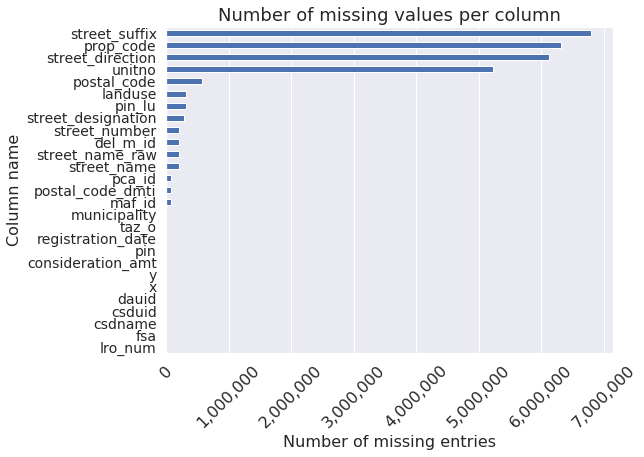

In [104]:
na_count = df.isnull().sum().sort_values()

f, ax = plt.subplots(1, figsize=(8, 6))
na_count.plot(kind='barh', ax=ax)
ax.grid(axis='y')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Number of missing values per column", fontsize=18)
ax.set_ylabel("Column name", fontsize=16)
ax.set_xlabel("Number of missing entries", fontsize=16)
plt.savefig('results/teranet_na_count.png', dpi=400, bbox_inches='tight')

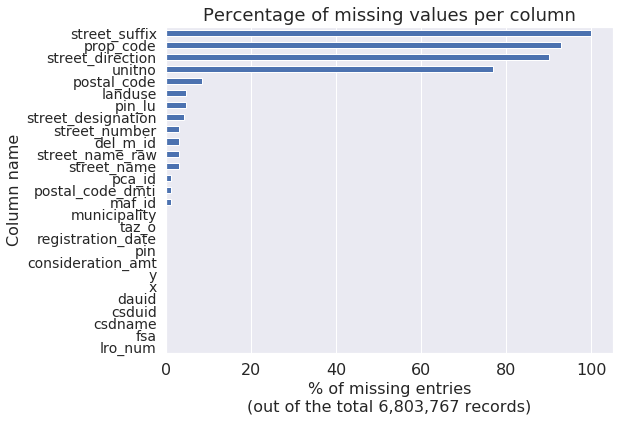

In [105]:
na_perc = df.isnull().sum().sort_values() / len(df) * 100

f, ax = plt.subplots(1, figsize=(8, 6))
na_perc.plot(kind='barh', ax=ax)
ax.grid(axis='y')
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Percentage of missing values per column", fontsize=18)
ax.set_ylabel("Column name", fontsize=16)
ax.set_xlabel("% of missing entries\n(out of the total {0:,} records)"
              .format(len(df)), fontsize=16)
plt.savefig('results/teranet_na_perc.png', dpi=400, bbox_inches='tight')

## Step 13: Remove column `street_suffix`
Since 99.99994% of the values in column `street_suffix` are missing, it has been removed from the dataset.

In [106]:
df = df.drop('street_suffix', axis=1)
print("Column 'street_suffix' was removed from the dataset.")

Column 'street_suffix' was removed from the dataset.


## Step 14: fix inconsistent values
Inconsistent entries are fixed in the following columns:
* Step 14.1: `street_direction`
* Step 14.2: `street_designaction`
* Step 14.3: `municipality`
* Step 14.4: `street_name`
* Step 14.5: `unitno`

### Step 14.1: Fix inconsistent values in column `street_direction`
Two Teranet records have `street_direction` = 'ES'. As it is unclear what should that correspond to (records correspond to the two transactions coming from some remote area north of Milton), their `street_direction` is reset to NaN (missing). Thus, `street_direction` for all Teranet records can be encoded as a singe character (catergory) that is either 'W', 'E', 'S', 'N', or NaN (missing).

In [107]:
df['street_direction'].value_counts()

W        316489
E        219818
N         70161
S         51637
West      11403
East       9193
North      2816
South      1607
N.          191
WEST        115
W.            6
ES            2
E.            2
NORTH         1
Name: street_direction, dtype: int64

#### Reset 'ES' to NaN

In [108]:
mask1 = df['street_direction'].str.match('ES', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

ES    2
Name: street_direction, dtype: int64

In [109]:
df.loc[mask1, 'street_direction'] = np.nan
df.loc[mask1, 'street_direction'].value_counts()

Series([], Name: street_direction, dtype: int64)

#### 'W'

In [110]:
mask1 = df['street_direction'].str.match('^W', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

W       316489
West     11403
WEST       115
W.           6
Name: street_direction, dtype: int64

In [111]:
df.loc[mask1, 'street_direction'] = 'W'
df.loc[mask1, 'street_direction'].value_counts()

W    328013
Name: street_direction, dtype: int64

#### 'E'

In [112]:
mask1 = df['street_direction'].str.match('^E', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

E       219818
East      9193
E.           2
Name: street_direction, dtype: int64

In [113]:
df.loc[mask1, 'street_direction'] = 'E'
df.loc[mask1, 'street_direction'].value_counts()

E    229013
Name: street_direction, dtype: int64

#### 'N'

In [114]:
mask1 = df['street_direction'].str.match('^N', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

N        70161
North     2816
N.         191
NORTH        1
Name: street_direction, dtype: int64

In [115]:
df.loc[mask1, 'street_direction'] = 'N'
df.loc[mask1, 'street_direction'].value_counts()

N    73169
Name: street_direction, dtype: int64

#### 'S'

In [116]:
mask1 = df['street_direction'].str.match('^S', case=False, na=False)
df.loc[mask1, 'street_direction'].value_counts()

S        51637
South     1607
Name: street_direction, dtype: int64

In [117]:
df.loc[mask1, 'street_direction'] = 'S'
df.loc[mask1, 'street_direction'].value_counts()

S    53244
Name: street_direction, dtype: int64

#### All inconsistent entries in column `street_direction` have been fixed.

In [118]:
df['street_direction'].value_counts()

W    328013
E    229013
N     73169
S     53244
Name: street_direction, dtype: int64

### Step 14.2: Fix inconsistent values in column `street_designation`
Street types were corrected in accordance with the [list of symbols and abbreviations](https://www.canadapost.ca/tools/pg/manual/PGaddress-e.asp?ecid=murl10006450) recognized by Canada Post. Only the values that needed correction are presented.

#### Abbey

In [119]:
mask1 = df['street_designation'].str.contains('Ab', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Abbey    11
Abe       4
Name: street_designation, dtype: int64

In [120]:
df.loc[mask1, 'street_designation'] = 'Abbey'
df.loc[mask1, 'street_designation'].value_counts()

Abbey    15
Name: street_designation, dtype: int64

#### Ave

In [121]:
mask1 = df['street_designation'].str.contains('Av', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Ave       1125986
Avenue      31482
Av           2061
Ave 5           2
Name: street_designation, dtype: int64

In [122]:
df.loc[mask1, 'street_designation'] = 'Ave'
df.loc[mask1, 'street_designation'].value_counts()

Ave    1159531
Name: street_designation, dtype: int64

#### Blvd

In [123]:
mask1 = df['street_designation'].str.contains('(bl|bo)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Blvd         325269
Boulevard     14041
Name: street_designation, dtype: int64

In [124]:
df.loc[mask1, 'street_designation'] = 'Blvd'
df.loc[mask1, 'street_designation'].value_counts()

Blvd    339310
Name: street_designation, dtype: int64

#### Cir

In [125]:
mask1 = df['street_designation'].str.contains('(cir$|circl)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Cir       133367
Circle      5616
Name: street_designation, dtype: int64

In [126]:
df.loc[mask1, 'street_designation'] = 'Cir'
df.loc[mask1, 'street_designation'].value_counts()

Cir    138983
Name: street_designation, dtype: int64

#### Crt

In [127]:
mask1 = df['street_designation'].str.contains('(Crt|Cou)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Crt      299387
Court     10876
Name: street_designation, dtype: int64

In [128]:
df.loc[mask1, 'street_designation'] = 'Crt'
df.loc[mask1, 'street_designation'].value_counts()

Crt    310263
Name: street_designation, dtype: int64

#### Cres

In [129]:
mask1 = df['street_designation'].str.contains('^Cre', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Cres        662213
Crescent     28068
Cresent         74
Name: street_designation, dtype: int64

In [130]:
df.loc[mask1, 'street_designation'] = 'Cres'
df.loc[mask1, 'street_designation'].value_counts()

Cres    690355
Name: street_designation, dtype: int64

#### Dell

In [131]:
mask1 = df['street_designation'].str.contains('^de', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Dell    19
De       2
Name: street_designation, dtype: int64

In [132]:
df.loc[mask1, 'street_designation'] = 'Dell'
df.loc[mask1, 'street_designation'].value_counts()

Dell    21
Name: street_designation, dtype: int64

#### Dr

In [133]:
mask1 = df['street_designation'].str.contains('Dr', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Dr          1076090
Drive         39475
Driveway       1997
Name: street_designation, dtype: int64

In [134]:
df.loc[mask1, 'street_designation'] = 'Dr'
df.loc[mask1, 'street_designation'].value_counts()

Dr    1117562
Name: street_designation, dtype: int64

#### Espl

In [135]:
mask1 = df['street_designation'].str.contains('^es', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Espl         8296
Esplanade    3487
Name: street_designation, dtype: int64

In [136]:
df.loc[mask1, 'street_designation'] = 'Espl'
df.loc[mask1, 'street_designation'].value_counts()

Espl    11783
Name: street_designation, dtype: int64

#### Landing

In [137]:
mask1 = df['street_designation'].str.contains('^land', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Landng     1272
Landing       2
Name: street_designation, dtype: int64

In [138]:
df.loc[mask1, 'street_designation'] = 'Landng'
df.loc[mask1, 'street_designation'].value_counts()

Landng    1274
Name: street_designation, dtype: int64

#### Lane

In [139]:
mask1 = df['street_designation'].str.contains('(lane|lanes|ln)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Lane     109029
Lanes        86
Ln           13
Name: street_designation, dtype: int64

In [140]:
df.loc[mask1, 'street_designation'] = 'Lane'
df.loc[mask1, 'street_designation'].value_counts()

Lane    109128
Name: street_designation, dtype: int64

#### Link

In [141]:
mask1 = df['street_designation'].str.contains('link', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Linkway    2458
Link         32
Name: street_designation, dtype: int64

In [142]:
df.loc[mask1, 'street_designation'] = 'Link'
df.loc[mask1, 'street_designation'].value_counts()

Link    2490
Name: street_designation, dtype: int64

#### Pky

In [143]:
mask1 = df['street_designation'].str.contains('(parkw|pky|pkwy)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Pky        20790
Pkwy           9
Parkway        8
Name: street_designation, dtype: int64

In [144]:
df.loc[mask1, 'street_designation'] = 'Pky'
df.loc[mask1, 'street_designation'].value_counts()

Pky    20807
Name: street_designation, dtype: int64

#### Pl

In [145]:
mask1 = df['street_designation'].str.contains('(^Pl$|Place)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Pl       117619
Place      2963
Name: street_designation, dtype: int64

In [146]:
df.loc[mask1, 'street_designation'] = 'Pl'
df.loc[mask1, 'street_designation'].value_counts()

Pl    120582
Name: street_designation, dtype: int64

#### Rd

In [147]:
mask1 = df['street_designation'].str.contains('(rd|roa)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Rd           884450
Road          48233
Sideroad       3685
Side rd        3118
Side road        83
Rd 30             5
Rd w              2
Name: street_designation, dtype: int64

In [148]:
df.loc[mask1, 'street_designation'] = 'Rd'
df.loc[mask1, 'street_designation'].value_counts()

Rd    939576
Name: street_designation, dtype: int64

#### St

In [149]:
mask1 = df['street_designation'].str.contains('^St', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

St        1018781
Street      47626
Name: street_designation, dtype: int64

In [150]:
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_designation'].value_counts()

St    1066407
Name: street_designation, dtype: int64

#### Sq

In [151]:
mask1 = df['street_designation'].str.contains('Sq', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Sq        47098
Square     1937
Name: street_designation, dtype: int64

In [152]:
df.loc[mask1, 'street_designation'] = 'Sq'
df.loc[mask1, 'street_designation'].value_counts()

Sq    49035
Name: street_designation, dtype: int64

#### Terr

In [153]:
mask1 = df['street_designation'].str.contains('Terr', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Terr       31332
Terrace     1147
Name: street_designation, dtype: int64

In [154]:
df.loc[mask1, 'street_designation'] = 'Terr'
df.loc[mask1, 'street_designation'].value_counts()

Terr    32479
Name: street_designation, dtype: int64

#### Terr

In [155]:
mask1 = df['street_designation'].str.contains('(Tra|Trl)', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Trail    80732
Trl          4
Name: street_designation, dtype: int64

In [156]:
df.loc[mask1, 'street_designation'] = 'Trail'
df.loc[mask1, 'street_designation'].value_counts()

Trail    80736
Name: street_designation, dtype: int64

#### Vale

In [157]:
mask1 = df['street_designation'].str.contains('Val', case=False, na=False)
df.loc[mask1, 'street_designation'].value_counts()

Vallee    105
Vale      101
Name: street_designation, dtype: int64

In [158]:
df.loc[mask1, 'street_designation'] = 'Vale'
df.loc[mask1, 'street_designation'].value_counts()

Vale    206
Name: street_designation, dtype: int64

#### Correct erratic entries: 48 refers to Highway 48

In [159]:
mask1 = df['street_designation'] == '48'
df[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,...,taz_o,fsa,pca_id,postal_code_dmti,maf_id,del_m_id,pin_lu,landuse,prop_code,street_name_raw
706283,65,35430323,280000.0,2009-08-07,NaN,NaN,Highway,48,NaN,Georgina,...,1348.0,L0E,180178265.0,L0E1R0,350002199.0,LB0001,35430323.0,1.0,NaN,Highway
706332,65,35430323,315000.0,2013-05-30,NaN,NaN,Highway,48,NaN,Georgina,...,1348.0,L0E,180178265.0,L0E1R0,350002199.0,LB0001,35430323.0,1.0,NaN,Highway
706405,65,35430323,270000.0,2003-03-05,NaN,NaN,Highway,48,NaN,Georgina,...,1348.0,L0E,180178265.0,L0E1R0,350002199.0,LB0001,35430323.0,1.0,NaN,Highway
706469,65,35430323,295000.0,2006-11-15,NaN,NaN,Highway,48,NaN,Georgina,...,1348.0,L0E,180178265.0,L0E1R0,350002199.0,LB0001,35430323.0,1.0,NaN,Highway


In [160]:
df.loc[mask1, 'street_designation'] = 'Highway'
df.loc[mask1, 'street_name'] = 'Highway 48'
df.loc[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,...,taz_o,fsa,pca_id,postal_code_dmti,maf_id,del_m_id,pin_lu,landuse,prop_code,street_name_raw
706283,65,35430323,280000.0,2009-08-07,NaN,NaN,Highway 48,Highway,NaN,Georgina,...,1348.0,L0E,180178265.0,L0E1R0,350002199.0,LB0001,35430323.0,1.0,NaN,Highway
706332,65,35430323,315000.0,2013-05-30,NaN,NaN,Highway 48,Highway,NaN,Georgina,...,1348.0,L0E,180178265.0,L0E1R0,350002199.0,LB0001,35430323.0,1.0,NaN,Highway
706405,65,35430323,270000.0,2003-03-05,NaN,NaN,Highway 48,Highway,NaN,Georgina,...,1348.0,L0E,180178265.0,L0E1R0,350002199.0,LB0001,35430323.0,1.0,NaN,Highway
706469,65,35430323,295000.0,2006-11-15,NaN,NaN,Highway 48,Highway,NaN,Georgina,...,1348.0,L0E,180178265.0,L0E1R0,350002199.0,LB0001,35430323.0,1.0,NaN,Highway


#### Correct erratic entries: Ctr refers to South Town Centre Blvd in Markham

In [161]:
mask1 = df['street_designation'].str.match('ctr', case=False, na=False)
df[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,...,taz_o,fsa,pca_id,postal_code_dmti,maf_id,del_m_id,pin_lu,landuse,prop_code,street_name_raw
4940546,65,298440671,29000000.0,2007-12-18,NaN,611,South Town,Ctr,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4940884,65,298440700,29000000.0,2007-12-18,NaN,901,South Town,Ctr,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4941191,65,298440651,29000000.0,2007-12-18,NaN,901,South Town,Ctr,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4941339,65,298440963,29000000.0,2007-12-18,NaN,107,South Town,Ctr,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4947167,65,298440700,282320.0,2012-01-27,NaN,901,South Town,Ctr,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4947457,65,298440671,282320.0,2012-01-27,NaN,611,South Town,Ctr,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4947777,65,298440963,282320.0,2012-01-27,NaN,107,South Town,Ctr,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4948007,65,298440651,282320.0,2012-01-27,NaN,901,South Town,Ctr,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4948483,65,298440700,2.0,2012-06-01,NaN,901,South Town,Ctr,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4948546,65,298440671,2.0,2012-06-01,NaN,611,South Town,Ctr,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town


In [162]:
df.loc[mask1, 'street_designation'] = 'Blvd'
df.loc[mask1, 'street_name'] = 'South Town Centre'
df.loc[mask1]

,lro_num,pin,consideration_amt,registration_date,postal_code,unitno,street_name,street_designation,street_direction,municipality,...,taz_o,fsa,pca_id,postal_code_dmti,maf_id,del_m_id,pin_lu,landuse,prop_code,street_name_raw
4940546,65,298440671,29000000.0,2007-12-18,NaN,611,South Town Centre,Blvd,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4940884,65,298440700,29000000.0,2007-12-18,NaN,901,South Town Centre,Blvd,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4941191,65,298440651,29000000.0,2007-12-18,NaN,901,South Town Centre,Blvd,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4941339,65,298440963,29000000.0,2007-12-18,NaN,107,South Town Centre,Blvd,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4947167,65,298440700,282320.0,2012-01-27,NaN,901,South Town Centre,Blvd,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4947457,65,298440671,282320.0,2012-01-27,NaN,611,South Town Centre,Blvd,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4947777,65,298440963,282320.0,2012-01-27,NaN,107,South Town Centre,Blvd,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4948007,65,298440651,282320.0,2012-01-27,NaN,901,South Town Centre,Blvd,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4948483,65,298440700,2.0,2012-06-01,NaN,901,South Town Centre,Blvd,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town
4948546,65,298440671,2.0,2012-06-01,NaN,611,South Town Centre,Blvd,NaN,Markham,...,1176.0,L6G,180314134.0,L6G1E3,350005326.0,NaN,30339502.0,98.0,NaN,South Town


#### All inconsistent entries in column `street_designation` have been fixed.

### Step 14.3: Fix inconsistent values in column `municipality`
`municipality` values were corrected in accordance with the 27 municipality names used for Dissemination Areas (DAs), as can be found in column `csdname` that was added to Teranet records via the spatial join performed during _Step 2.1_ of the cleanup process. Teranet records have a lot more different `municipality` names, such as 'York', 'East York', 'North York', 'Etobicoke', or smaller towns in GTHA, these values were left untouched; `municipality` names corresponding to major GTHA municipalities, that are used for DAs and can be found in column `csdname`, have been corrected to match the spelling found in Census datasets. 

In [163]:
df['csdname'].value_counts()

Toronto                          2785059
Mississauga                       703800
Brampton                          495970
Hamilton                          482691
Markham                           314783
Vaughan                           305212
Richmond Hill                     214837
Oakville                          210181
Burlington                        208953
Oshawa                            134041
Whitby                            110045
Milton                             94208
Ajax                               88102
Clarington                         86850
Caledon                            86725
Pickering                          86694
Newmarket                          73254
Halton Hills                       61429
Georgina                           59921
Aurora                             53802
Whitchurch-Stouffville             40728
King                               24894
Scugog                             23834
East Gwillimbury                   23568
Uxbridge        

### Toronto

In [164]:
mask1 = df['municipality'].str.contains('Toro', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Toronto               1778555
North York/Toronto        168
City Of Toronto            57
Islington/Toronto           3
Name: municipality, dtype: int64

In [165]:
df.loc[mask1, 'municipality'] = 'Toronto'
df.loc[mask1, 'municipality'].value_counts()

Toronto    1778783
Name: municipality, dtype: int64

### Mississauga

In [166]:
mask1 = df['municipality'].str.contains('Mis', na=False, case=False)
mask2 = df['municipality'].str.contains('\sof\s', na=False, case=False)
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Mississauga     703496
Mississsauga         2
Name: municipality, dtype: int64

In [167]:
df.loc[mask1 & ~mask2, 'municipality'] = 'Mississauga'
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Mississauga    703498
Name: municipality, dtype: int64

### Hamilton

In [168]:
mask1 = df['municipality'].str.contains('hami', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Hamilton            392133
Rural Hamilton        1214
City Of Hamilton       327
Hamilton City            2
Name: municipality, dtype: int64

In [169]:
df.loc[mask1, 'municipality'] = 'Hamilton'
df.loc[mask1, 'municipality'].value_counts()

Hamilton    393676
Name: municipality, dtype: int64

### Markham
#### Whit-Stouffville/Markham
Teranet records that have `municipality` value of 'Whit-Stouffville/Markham' are located in 'Whitchurch-Stouffville' according to their coordinates.

In [170]:
mask1 = df['municipality'] == 'Whit-Stouffville/Markham'
df.loc[mask1, ['municipality', 'csdname', 'y', 'x']]

,municipality,csdname,y,x
819540,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.936371,-79.380210
820014,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.936371,-79.380210
905599,Whit-Stouffville/Markham,Whitchurch-Stouffville,44.083982,-79.343559
1323348,Whit-Stouffville/Markham,Whitchurch-Stouffville,43.974472,-79.231358


In [171]:
df.loc[mask1, 'municipality'] = 'Whitchurch-Stouffville'
df.loc[mask1, 'municipality'].value_counts()

Whitchurch-Stouffville    4
Name: municipality, dtype: int64

#### Markham

In [172]:
mask1 = df['municipality'].str.contains('markh', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Markham            258678
City Of Markham         6
Name: municipality, dtype: int64

In [173]:
df.loc[mask1, 'municipality'] = 'Markham'
df.loc[mask1, 'municipality'].value_counts()

Markham    258684
Name: municipality, dtype: int64

### Caledon

In [174]:
mask1 = df['municipality'].str.contains('(caledon$|caledon\s)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Caledon            80549
Caledon East         338
Caledon Village       38
East Caledon           2
Name: municipality, dtype: int64

In [175]:
df.loc[mask1, 'municipality'] = 'Caledon'
df.loc[mask1, 'municipality'].value_counts()

Caledon    80927
Name: municipality, dtype: int64

### Pickering

In [176]:
mask1 = df['municipality'].str.contains('pick', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Pickering         86258
Pickering City        4
Name: municipality, dtype: int64

In [177]:
df.loc[mask1, 'municipality'] = 'Pickering'
df.loc[mask1, 'municipality'].value_counts()

Pickering    86262
Name: municipality, dtype: int64

### Newmarket

In [178]:
mask1 = df['municipality'].str.contains('newm', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Newmarket             71923
Newmarket Township     2310
Name: municipality, dtype: int64

In [179]:
df.loc[mask1, 'municipality'] = 'Newmarket'
df.loc[mask1, 'municipality'].value_counts()

Newmarket    74233
Name: municipality, dtype: int64

### Halton Hills
`municipality` value 'Halton' seems to correspond to a number of municipalities (Milton, Oakville, Halton Hills), as indicated by correcsponding values of `csdname`, and is left unchanged.

In [180]:
mask1 = df['municipality'].str.contains('halton\s', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Halton Hills    50528
Halton Hill         3
Name: municipality, dtype: int64

In [181]:
df.loc[mask1, 'municipality'] = 'Halton Hills'
df.loc[mask1, 'municipality'].value_counts()

Halton Hills    50531
Name: municipality, dtype: int64

### Georgina

In [182]:
mask1 = df['municipality'].str.contains('georgi', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Georgina            35316
Town Of Georgina        9
Name: municipality, dtype: int64

In [183]:
df.loc[mask1, 'municipality'] = 'Georgina'
df.loc[mask1, 'municipality'].value_counts()

Georgina    35325
Name: municipality, dtype: int64

### Whitchurch-Stouffville

In [184]:
mask1 = df['municipality'].str.contains('(whitc|stou)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Whitchurch-Stouffville      20264
Stouffville                 16652
Whitchurch - Stouffville     2769
Whitchurch/Stouffville         23
Whitchurch                      2
Name: municipality, dtype: int64

In [185]:
df.loc[mask1, 'municipality'] = 'Whitchurch-Stouffville'
df.loc[mask1, 'municipality'].value_counts()

Whitchurch-Stouffville    39710
Name: municipality, dtype: int64

### King

In [186]:
mask1 = df['municipality'].str.contains('(king$|king\s)', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

King             10246
King City         6874
King Township     2699
Name: municipality, dtype: int64

In [187]:
df.loc[mask1, 'municipality'] = 'King'
df.loc[mask1, 'municipality'].value_counts()

King    19819
Name: municipality, dtype: int64

### Scugog

In [188]:
mask1 = df['municipality'].str.contains('scu', na=False, case=False)
mask2 = df['municipality'].str.contains('mississ', na=False, case=False)
df.loc[mask1 & ~mask2, 'municipality'].value_counts()

Scugog             16005
Scugog Township     2445
Name: municipality, dtype: int64

In [189]:
df.loc[mask1, 'municipality'] = 'Scugog'
df.loc[mask1, 'municipality'].value_counts()

Scugog    18456
Name: municipality, dtype: int64

### Uxbridge

In [190]:
mask1 = df['municipality'].str.contains('ux', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Uxbridge             18704
Uxbridge Township     1641
Name: municipality, dtype: int64

In [191]:
df.loc[mask1, 'municipality'] = 'Uxbridge'
df.loc[mask1, 'municipality'].value_counts()

Uxbridge    20345
Name: municipality, dtype: int64

### Brock

In [192]:
mask1 = df['municipality'].str.contains('brock$|brock\s', na=False, case=False)
df.loc[mask1, 'municipality'].value_counts()

Brock             7622
Brock Township    3953
Name: municipality, dtype: int64

In [193]:
df.loc[mask1, 'municipality'] = 'Brock'
df.loc[mask1, 'municipality'].value_counts()

Brock    11575
Name: municipality, dtype: int64

### Step 14.4: Inconsistent values in column `street_name`
Consistency of entries in column `street_name` was improved through parsing out zip codes, unit and street numbers, street directions and street designations in the previous steps. Corrections for most frequently encountered street names are made in this subsection.

In [194]:
df['street_name'].value_counts()

Yonge                      82528
King                       46727
Sheppard                   36154
Bay                        35939
Lakeshore                  32420
                           ...  
Alamo Hts                      1
Ballinger                      1
& 36 Anderson Boulevard        1
Ravendale Crt                  1
Wychwood Park                  1
Name: street_name, Length: 28746, dtype: int64

#### Yonge St

In [195]:
mask1 = df['street_name'].str.contains('yonge\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('(,|Tower|\/)', na=False, case=False)
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

Yonge Street                       89
Yonge Steet                         6
Yonge Stree                         5
Yonge Street South Of Ravenshoe     5
Yonge Street Ric                    2
Yonge Strret                        1
Yonge Sstreet                       1
Yonge Steeet                        1
Name: street_name, dtype: int64

In [196]:
df.loc[mask1 & ~mask2, 'street_name'] = 'Yonge'
df.loc[mask1 & ~mask2, 'street_designation'] = 'St'
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

Yonge    110
Name: street_name, dtype: int64

#### King St

In [197]:
mask1 = df['street_name'].str.contains('king\sstreet$|king\sst$|king\sst\.|king\sstreet,$', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

King Street     40
King St          8
King St.         3
King Street,     2
Name: street_name, dtype: int64

In [198]:
df.loc[mask1, 'street_name'] = 'King'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

King    53
Name: street_name, dtype: int64

#### Sheppard Ave

##### Fix street directions

In [199]:
mask1 = df['street_name'] == "Sheppard AveE."
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
536467,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536468,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536476,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536495,NaN,222,Sheppard AveE.,NaN,Willowdale,43.764049,-79.400651
536527,NaN,218,Sheppard AveE.,NaN,Willowdale,43.763952,-79.401102
536697,NaN,218,Sheppard AveE.,NaN,Willowdale,43.763952,-79.401102
536787,NaN,222,Sheppard AveE.,NaN,Willowdale,43.764049,-79.400651
536928,NaN,200,Sheppard AveE.,NaN,Willowdale,43.763833,-79.401759
536938,NaN,218,Sheppard AveE.,NaN,Willowdale,43.763952,-79.401102
813477,NaN,166,Sheppard AveE.,NaN,Willowdale,43.764131,-79.404090


In [200]:
df.loc[mask1, 'street_direction'] = 'E'
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
536467,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536468,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536476,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536495,NaN,222,Sheppard AveE.,E,Willowdale,43.764049,-79.400651
536527,NaN,218,Sheppard AveE.,E,Willowdale,43.763952,-79.401102
536697,NaN,218,Sheppard AveE.,E,Willowdale,43.763952,-79.401102
536787,NaN,222,Sheppard AveE.,E,Willowdale,43.764049,-79.400651
536928,NaN,200,Sheppard AveE.,E,Willowdale,43.763833,-79.401759
536938,NaN,218,Sheppard AveE.,E,Willowdale,43.763952,-79.401102
813477,NaN,166,Sheppard AveE.,E,Willowdale,43.764131,-79.404090


In [201]:
mask1 = df['street_name'] == "Sheppard AveW."
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
1652634,NaN,115,Sheppard AveW.,NaN,North York,43.759937,-79.416730
1652847,NaN,133,Sheppard AveW.,NaN,Willowdale,43.759736,-79.417652
1652901,NaN,137,Sheppard AveW.,NaN,North York,43.759712,-79.417744
1652904,NaN,115,Sheppard AveW.,NaN,North York,43.759937,-79.416730
1652920,NaN,109,Sheppard AveW.,NaN,North York,43.760000,-79.416439


In [202]:
df.loc[mask1, 'street_direction'] = 'W'
df.loc[mask1, ['unitno', 'street_number', 'street_name', 'street_direction', 'municipality', 'y', 'x']]

,unitno,street_number,street_name,street_direction,municipality,y,x
1652634,NaN,115,Sheppard AveW.,W,North York,43.759937,-79.416730
1652847,NaN,133,Sheppard AveW.,W,Willowdale,43.759736,-79.417652
1652901,NaN,137,Sheppard AveW.,W,North York,43.759712,-79.417744
1652904,NaN,115,Sheppard AveW.,W,North York,43.759937,-79.416730
1652920,NaN,109,Sheppard AveW.,W,North York,43.760000,-79.416439


##### Fix street name and street designation

In [203]:
mask1 = df['street_name'].str.contains('sheppard av', na=False, case=False)
mask2 = df['street_name'].str.contains('\(', na=False, case=False)
df.loc[mask1 & ~mask2, 'street_name'].value_counts()

Sheppard Avenue    91
Sheppard AveE.     13
Sheppard Ave        7
Sheppard AveW.      5
Name: street_name, dtype: int64

In [204]:
df.loc[mask1, 'street_name'] = 'Sheppard'
df.loc[mask1, 'street_designation'] = 'Ave'
df.loc[mask1, 'street_name'].value_counts()

Sheppard    119
Name: street_name, dtype: int64

#### Bloor St

##### Fix street number

In [205]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('\se', na=False, case=False)
mask3 = df['street_name'].str.contains('#', na=False)
df.loc[mask1 & mask2 & mask3, 'street_name'].value_counts()

Bloor Street East, #807    1
Name: street_name, dtype: int64

In [206]:
df.loc[mask1 & mask2 & mask3, 'street_number'] = 807
print("Street number fixed!")

Street number fixed!


##### Fix street direction

In [207]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
mask2 = df['street_name'].str.contains('\se', na=False, case=False)
df.loc[mask1 & mask2, 'street_name'].value_counts()

Bloor St Est               2
Bloor Street Est           1
Bloor Street East`         1
Bloor Street East, #807    1
Name: street_name, dtype: int64

In [208]:
df.loc[mask1 & mask2, 'street_direction'] = 'E'
print("Street direction fixed!")

Street direction fixed!


##### Fix street name and street designation

In [209]:
mask1 = df['street_name'].str.contains('^bloor\ss', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Bloor Streest              3
Bloor St Est               2
Bloor Sreet                2
Bloor Stree                2
Bloor Strret               1
Bloor Streeat              1
Bloor Street Est           1
Bloor Street East, #807    1
Bloor Street,              1
Bloor Street East`         1
Name: street_name, dtype: int64

In [210]:
df.loc[mask1, 'street_name'] = 'Bloor'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Bloor    15
Name: street_name, dtype: int64

#### Dundas St

In [211]:
mask1 = df['street_name'].str.contains('^Dundas\ss$|^dundas\sst', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Dundas Street        21
Dundas St.            3
Dundas Street,        2
Dundas S              1
Dundas St             1
Dundas St E Hwy 5     1
Name: street_name, dtype: int64

In [212]:
df.loc[mask1, 'street_name'] = 'Dundas'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Dundas    29
Name: street_name, dtype: int64

#### Front St

In [213]:
mask1 = df['street_name'].str.contains('Front\s', na=False, case=False)
df.loc[mask1, 'street_name'].value_counts()

Front Stree      1
Front Stereet    1
Front Street,    1
Name: street_name, dtype: int64

In [214]:
df.loc[mask1, 'street_name'] = 'Front'
df.loc[mask1, 'street_designation'] = 'St'
df.loc[mask1, 'street_name'].value_counts()

Front    3
Name: street_name, dtype: int64

There are many more inconsistencies present in column `street_name`, but since fixing all of them presents a time-intensive task, it is left until a future stage when targeted corrections can be performed where required.

### Step 14.5: Fix values in column `unitno`

#### 1.010000e-107

In [215]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.01')
mask3 = unit_no.str.match('1.009')
df.loc[mask1 & (mask2 | mask3), 'unitno']

340632    1.01e-107
Name: unitno, dtype: object

In [216]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 101
df.loc[mask1 & (mask2 | mask3), 'unitno']

340632    101
Name: unitno, dtype: object

#### 1.200000e-/+x
>It is impossible to tell, if this erratic unit number corresponds to '12', '120', or '1200'. All units that match this pattern have been converted to '12'.

In [217]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.199')
df.loc[mask1 & mask2, 'unitno']

3953659    1.2e-103
3953722    1.2e-200
3953745    1.2e-200
3953813    1.2e-200
3953847    1.2e-200
3954501    1.2e-200
3954608    1.2e-200
3954671    1.2e-200
3954704    1.2e-200
3954707    1.2e-103
3954750    1.2e-200
3954751    1.2e-200
3954753    1.2e-200
3954754    1.2e-200
3954827    1.2e-103
3955306    1.2e-103
Name: unitno, dtype: object

In [218]:
df.loc[mask1 & mask2, 'unitno'] = 12
df.loc[mask1 & mask2, 'unitno']

3953659    12
3953722    12
3953745    12
3953813    12
3953847    12
3954501    12
3954608    12
3954671    12
3954704    12
3954707    12
3954750    12
3954751    12
3954753    12
3954754    12
3954827    12
3955306    12
Name: unitno, dtype: object

#### 2.000000e-/+x
>It is impossible to tell, if this erratic unit number corresponds to '2', '20', or '200'. All units that match this pattern have been converted to '2'.

In [219]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('2')
mask3 = unit_no.str.match('1.99')
df.loc[mask1 & (mask2 | mask3), 'unitno']

803815      2e-22
804405      2e-22
804411      2e-22
976916     2e+105
980169     2e+155
980200     2e+155
985956     2e+105
1319494     2e-06
1319641     2e-05
1320036     2e-06
1745169     2e+18
1745170     2e+19
1745171     2e+21
1746296     2e+18
1746297     2e+19
1746298     2e+21
2898133    2e-123
2901835    2e-123
2902725    2e-123
4334152     2e-12
4334302     2e-12
4334377     2e-12
Name: unitno, dtype: object

In [220]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 2
df.loc[mask1 & (mask2 | mask3), 'unitno']

803815     2
804405     2
804411     2
976916     2
980169     2
980200     2
985956     2
1319494    2
1319641    2
1320036    2
1745169    2
1745170    2
1745171    2
1746296    2
1746297    2
1746298    2
2898133    2
2901835    2
2902725    2
4334152    2
4334302    2
4334377    2
Name: unitno, dtype: object

#### 1.100000e-201
>It is impossible to tell, if this erratic unit number corresponds to '11', '110', or '1100'. All units that match this pattern have been converted to '11'.

In [221]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.1')
mask3 = unit_no.str.match('1.09')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953681    1.1e-201
3953699    1.1e-201
3953739    1.1e-201
3954534    1.1e-201
3954552    1.1e-201
3954583    1.1e-201
3954843    1.1e-201
3954844    1.1e-201
3954845    1.1e-201
3955466    1.1e-201
3955468    1.1e-201
3955469    1.1e-201
Name: unitno, dtype: object

In [222]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 11
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953681    11
3953699    11
3953739    11
3954534    11
3954552    11
3954583    11
3954843    11
3954844    11
3954845    11
3955466    11
3955468    11
3955469    11
Name: unitno, dtype: object

#### 1.700000e-06
>It is impossible to tell, if this erratic unit number corresponds to '17', '170', or '1700'. All units that match this pattern have been converted to '17'.

In [223]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.7')
mask3 = unit_no.str.match('1.69')
df.loc[mask1 & (mask2 | mask3), 'unitno']

1288130    1.7e-06
1288498    1.7e-06
Name: unitno, dtype: object

In [224]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 17
df.loc[mask1 & (mask2 | mask3), 'unitno']

1288130    17
1288498    17
Name: unitno, dtype: object

#### 1.800000e-19
>It is impossible to tell, if this erratic unit number corresponds to '18', '180', or '1800'. All units that match this pattern have been converted to '18'.

In [225]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.8')
mask3 = unit_no.str.match('1.79')
df.loc[mask1 & (mask2 | mask3), 'unitno']

4939922    1.8e-19
Name: unitno, dtype: object

In [226]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 18
df.loc[mask1 & (mask2 | mask3), 'unitno']

4939922    18
Name: unitno, dtype: object

#### 3.300000e-33
>It is impossible to tell, if this erratic unit number corresponds to '33', '330', or '3300'. All units that match this pattern have been converted to '33'.

In [227]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('3.3')
mask3 = unit_no.str.match('3.29')
df.loc[mask1 & (mask2 | mask3), 'unitno']

410183    3.3e-33
410513    3.3e-33
410520    3.3e-33
Name: unitno, dtype: object

In [228]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 33
df.loc[mask1 & (mask2 | mask3), 'unitno']

410183    33
410513    33
410520    33
Name: unitno, dtype: object

#### 6.000000e-x
>It is impossible to tell, if this erratic unit number corresponds to '6', '60', or '600'. All units that match this pattern have been converted to '6'.

In [229]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('6')
mask3 = unit_no.str.match('5.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

2900983     6e-22
2902625     6e-22
3953683    6e-104
3953687    6e-104
3953747    6e-201
3953776    6e-201
3953787    6e-201
3953795    6e-201
3953843    6e-201
3954476    6e-201
3954500    6e-201
3954541    6e-201
3954561    6e-201
3954588    6e-104
3954681    6e-201
3954697    6e-104
3954731    6e-104
3954733    6e-104
3954788    6e-201
3954789    6e-201
3954790    6e-201
3954791    6e-201
3954792    6e-201
3955504    6e-104
3955506    6e-104
Name: unitno, dtype: object

In [230]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 6
df.loc[mask1 & (mask2 | mask3), 'unitno']

2900983    6
2902625    6
3953683    6
3953687    6
3953747    6
3953776    6
3953787    6
3953795    6
3953843    6
3954476    6
3954500    6
3954541    6
3954561    6
3954588    6
3954681    6
3954697    6
3954731    6
3954733    6
3954788    6
3954789    6
3954790    6
3954791    6
3954792    6
3955504    6
3955506    6
Name: unitno, dtype: object

#### 5.000000e-x
>It is impossible to tell, if this erratic unit number corresponds to '5', '50', or '500'. All units that match this pattern have been converted to '5'.

In [231]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('5')
mask3 = unit_no.str.match('4.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953654    5e-103
3953730    5e-102
3953753    5e-103
3953849    5e-102
3954530    5e-103
3954550    5e-103
3954616    5e-102
3954702    5e-102
3954821    5e-102
3954823    5e-102
3954893    5e-103
3954894    5e-103
4287873     5e-06
4287874     5e-06
Name: unitno, dtype: object

In [232]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 5
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953654    5
3953730    5
3953753    5
3953849    5
3954530    5
3954550    5
3954616    5
3954702    5
3954821    5
3954823    5
3954893    5
3954894    5
4287873    5
4287874    5
Name: unitno, dtype: object

#### 1.000000e-/+21
>It is impossible to tell, if this erratic unit number corresponds to '1', '10', or '100'. All units that match this pattern have been converted to '1'.

In [233]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1')
mask3 = unit_no.str.match('0.9')
id_list = [3953792, 3954603, 3954834]
mask4 = unit_no.index.isin(id_list)
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno']

1745113    1e+21
1745173    1e+18
1745174    1e+20
1745175    1e+22
1745176    1e+25
1745177    1e+27
1745180    1e+19
1745181    1e+17
1745182    1e+21
1745196    1e+26
1745198    1e+23
1745221    1e+17
1745230    1e+16
1745356    1e+19
1745472    1e+17
1745473    1e+19
1745474    1e+21
1745475    1e+23
1745563    1e+26
1745702    1e+26
1746252    1e+20
1746253    1e+27
1746254    1e+22
1746255    1e+25
1746256    1e+18
1746476    1e+17
2908794    1e-10
2908862    1e-10
2908998    1e-10
2909139    1e-10
3822336    1e-05
3822337    1e-05
3822338    1e-05
3822339    1e-05
3822340    1e-05
3953792      102
3954603      NaN
3954834      NaN
4989682    1e-20
4989684    1e-20
4989709    1e-20
Name: unitno, dtype: object

In [234]:
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno'] = 1
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno']

1745113    1
1745173    1
1745174    1
1745175    1
1745176    1
1745177    1
1745180    1
1745181    1
1745182    1
1745196    1
1745198    1
1745221    1
1745230    1
1745356    1
1745472    1
1745473    1
1745474    1
1745475    1
1745563    1
1745702    1
1746252    1
1746253    1
1746254    1
1746255    1
1746256    1
1746476    1
2908794    1
2908862    1
2908998    1
2909139    1
3822336    1
3822337    1
3822338    1
3822339    1
3822340    1
3953792    1
3954603    1
3954834    1
4989682    1
4989684    1
4989709    1
Name: unitno, dtype: object

#### 9.000000e-104
>It is impossible to tell, if this erratic unit number corresponds to '9', '90', or '900'. All units that match this pattern have been converted to '9'.

In [235]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('9')
mask3 = unit_no.str.match('8.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953855    9e-104
3953863    1e-101
3954674    1e-101
3954680    9e-104
3954839    9e-104
3954905    1e-101
3955026    9e-104
3955113    9e-104
3956157    9e-104
3956610    9e-104
Name: unitno, dtype: object

In [236]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 9
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953855    9
3953863    9
3954674    9
3954680    9
3954839    9
3954905    9
3955026    9
3955113    9
3956157    9
3956610    9
Name: unitno, dtype: object

#### 4.000000e-104
>It is impossible to tell, if this erratic unit number corresponds to '4', '40', or '400'. All units that match this pattern have been converted to '4'.

In [237]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('4')
mask3 = unit_no.str.match('3.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953784    4e-104
3954695    4e-104
3954825    4e-104
3956053    4e-104
Name: unitno, dtype: object

In [238]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 4
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953784    4
3954695    4
3954825    4
3956053    4
Name: unitno, dtype: object

#### 0.01

In [239]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.01')
df.loc[mask1, 'unitno']

15869    0.01
79223    0.01
79415    0.01
79480    0.01
80122    0.01
Name: unitno, dtype: object

In [240]:
df.loc[mask1, 'unitno'] = 1
df.loc[mask1, 'unitno']

15869    1
79223    1
79415    1
79480    1
80122    1
Name: unitno, dtype: object

#### 0.37

In [241]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.37')
df.loc[mask1, 'unitno']

836969    0.37
839755    0.37
851340    0.37
859848    0.37
865507    0.37
Name: unitno, dtype: object

In [242]:
df.loc[mask1, 'unitno'] = 37
df.loc[mask1, 'unitno']

836969    37
839755    37
851340    37
859848    37
865507    37
Name: unitno, dtype: object

#### 0.000815

In [243]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.000815')
df.loc[mask1, 'unitno']

4449832    0.000815
4449833    0.000815
4451667    0.000815
4451668    0.000815
Name: unitno, dtype: object

In [244]:
df.loc[mask1, 'unitno'] = 815
df.loc[mask1, 'unitno']

4449832    815
4449833    815
4451667    815
4451668    815
Name: unitno, dtype: object

#### 0.033

In [245]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.033')
df.loc[mask1, 'unitno']

853114    0.033
Name: unitno, dtype: object

In [246]:
df.loc[mask1, 'unitno'] = 33
df.loc[mask1, 'unitno']

853114    33
Name: unitno, dtype: object

#### 0.24

In [247]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.24')
df.loc[mask1, 'unitno']

3419863    0.24
3420085    0.24
3420351    0.24
3420568    0.24
Name: unitno, dtype: object

In [248]:
df.loc[mask1, 'unitno'] = 24
df.loc[mask1, 'unitno']

3419863    24
3420085    24
3420351    24
3420568    24
Name: unitno, dtype: object

#### 0.2

In [249]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.2')
df.loc[mask1, 'unitno']

1319375    0.2
3234597    0.2
3234675    0.2
3234752    0.2
4334026    0.2
4334048    0.2
4334115    0.2
4334117    0.2
4334119    0.2
4334122    0.2
4334166    0.2
4334203    0.2
4334222    0.2
4334262    0.2
4334264    0.2
4334273    0.2
4334378    0.2
4334397    0.2
4334430    0.2
4334431    0.2
4334432    0.2
4334437    0.2
4334470    0.2
Name: unitno, dtype: object

In [250]:
df.loc[mask1, 'unitno'] = 2
df.loc[mask1, 'unitno']

1319375    2
3234597    2
3234675    2
3234752    2
4334026    2
4334048    2
4334115    2
4334117    2
4334119    2
4334122    2
4334166    2
4334203    2
4334222    2
4334262    2
4334264    2
4334273    2
4334378    2
4334397    2
4334430    2
4334431    2
4334432    2
4334437    2
4334470    2
Name: unitno, dtype: object

#### 0.003

In [251]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.003')
df.loc[mask1, 'unitno']

4334107    0.003
4334130    0.003
4334181    0.003
4334202    0.003
4334243    0.003
4334284    0.003
4334387    0.003
4334398    0.003
4334414    0.003
Name: unitno, dtype: object

In [252]:
df.loc[mask1, 'unitno'] = 3
df.loc[mask1, 'unitno']

4334107    3
4334130    3
4334181    3
4334202    3
4334243    3
4334284    3
4334387    3
4334398    3
4334414    3
Name: unitno, dtype: object

#### 0.04

In [253]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.04')
df.loc[mask1, 'unitno']

4334186    0.04
4334374    0.04
Name: unitno, dtype: object

In [254]:
df.loc[mask1, 'unitno'] = 4
df.loc[mask1, 'unitno']

4334186    4
4334374    4
Name: unitno, dtype: object

#### 0.001

In [255]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.001')
df.loc[mask1, 'unitno']

2611722    0.001
2612472    0.001
2612473    0.001
2612477    0.001
2612807    0.001
2612808    0.001
2612809    0.001
Name: unitno, dtype: object

In [256]:
df.loc[mask1, 'unitno'] = 1
df.loc[mask1, 'unitno']

2611722    1
2612472    1
2612473    1
2612477    1
2612807    1
2612808    1
2612809    1
Name: unitno, dtype: object

#### 0.0026

In [257]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.0026')
df.loc[mask1, 'unitno']

2898714    0.0026
2900813    0.0026
2902408    0.0026
Name: unitno, dtype: object

In [258]:
df.loc[mask1, 'unitno'] = 26
df.loc[mask1, 'unitno']

2898714    26
2900813    26
2902408    26
Name: unitno, dtype: object

#### 0.0024

In [259]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.0024')
df.loc[mask1, 'unitno']

1288132    0.0024
1288499    0.0024
Name: unitno, dtype: object

In [260]:
df.loc[mask1, 'unitno'] = 24
df.loc[mask1, 'unitno']

1288132    24
1288499    24
Name: unitno, dtype: object

#### 0.66

In [261]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.66')
df.loc[mask1, 'unitno']

3861785    0.66
3862109    0.66
3862332    0.66
3868597    0.66
3870406    0.66
Name: unitno, dtype: object

In [262]:
df.loc[mask1, 'unitno'] = 66
df.loc[mask1, 'unitno']

3861785    66
3862109    66
3862332    66
3868597    66
3870406    66
Name: unitno, dtype: object

#### 0.83

In [263]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0\.83')
df.loc[mask1, 'unitno']

1067357    0.83
1067901    0.83
1069057    0.83
Name: unitno, dtype: object

In [264]:
df.loc[mask1, 'unitno'] = 83
df.loc[mask1, 'unitno']

1067357    83
1067901    83
1069057    83
Name: unitno, dtype: object

#### 3.01

In [265]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^3\.01$')
df.loc[mask1, 'unitno']

1927330    3.01
1927331    3.01
1927332    3.01
1927333    3.01
1927398    3.01
1927399    3.01
1927400    3.01
1927401    3.01
Name: unitno, dtype: object

In [266]:
df.loc[mask1, 'unitno'] = 301
df.loc[mask1, 'unitno']

1927330    301
1927331    301
1927332    301
1927333    301
1927398    301
1927399    301
1927400    301
1927401    301
Name: unitno, dtype: object

#### 1.5

In [267]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1.5$')
df.loc[mask1, 'unitno']

801982    1.5
803281    1.5
Name: unitno, dtype: object

In [268]:
df.loc[mask1, 'unitno'] = 15
df.loc[mask1, 'unitno']

801982    15
803281    15
Name: unitno, dtype: object

#### 1.6

In [269]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1\.6$')
df.loc[mask1, 'unitno']

801983    1.6
803284    1.6
Name: unitno, dtype: object

In [270]:
df.loc[mask1, 'unitno'] = 16
df.loc[mask1, 'unitno']

801983    16
803284    16
Name: unitno, dtype: object

#### 4.2

In [271]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^4\.2$')
df.loc[mask1, 'unitno']

6239704    4.2
6244187    4.2
Name: unitno, dtype: object

In [272]:
df.loc[mask1, 'unitno'] = 42
df.loc[mask1, 'unitno']

6239704    42
6244187    42
Name: unitno, dtype: object

#### 7.9

In [273]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^7\.9$')
df.loc[mask1, 'unitno']

2994524    7.9
2996026    7.9
Name: unitno, dtype: object

In [274]:
df.loc[mask1, 'unitno'] = 79
df.loc[mask1, 'unitno']

2994524    79
2996026    79
Name: unitno, dtype: object

#### 1.9

In [275]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1\.9$')
df.loc[mask1, 'unitno']

2734938    1.9
2735353    1.9
2735660    1.9
Name: unitno, dtype: object

In [276]:
df.loc[mask1, 'unitno'] = 19
df.loc[mask1, 'unitno']

2734938    19
2735353    19
2735660    19
Name: unitno, dtype: object

#### 9.5

In [277]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^9\.5$')
df.loc[mask1, 'unitno']

2672397    9.5
2673438    9.5
2675613    9.5
2675615    9.5
Name: unitno, dtype: object

In [278]:
df.loc[mask1, 'unitno'] = 95
df.loc[mask1, 'unitno']

2672397    95
2673438    95
2675613    95
2675615    95
Name: unitno, dtype: object

#### 0.02, 0.002, and 0.0002

In [279]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^0')
mask2 = unit_no.str.contains('2')
df.loc[mask1 & mask2, 'unitno']

1319385     0.002
1319579      0.02
1319627    0.0002
1320423      0.02
Name: unitno, dtype: object

In [280]:
df.loc[mask1 & mask2, 'unitno'] = 2
df.loc[mask1 & mask2, 'unitno']

1319385    2
1319579    2
1319627    2
1320423    2
Name: unitno, dtype: object

#### 4.7

In [281]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^4\.7$')
df.loc[mask1, 'unitno']

853115    4.7
Name: unitno, dtype: object

In [282]:
df.loc[mask1, 'unitno'] = 47
df.loc[mask1, 'unitno']

853115    47
Name: unitno, dtype: object

#### 6.5

In [283]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^6\.5$')
df.loc[mask1, 'unitno']

1963026    6.5
Name: unitno, dtype: object

In [284]:
df.loc[mask1, 'unitno'] = 65
df.loc[mask1, 'unitno']

1963026    65
Name: unitno, dtype: object

#### 3.5

In [285]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^3\.5$')
df.loc[mask1, 'unitno']

1963030    3.5
Name: unitno, dtype: object

In [286]:
df.loc[mask1, 'unitno'] = 35
df.loc[mask1, 'unitno']

1963030    35
Name: unitno, dtype: object

#### 16.9

In [287]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.9$')
df.loc[mask1, 'unitno']

1963050    16.9
1963118    16.9
1964185    16.9
Name: unitno, dtype: object

In [288]:
df.loc[mask1, 'unitno'] = 169
df.loc[mask1, 'unitno']

1963050    169
1963118    169
1964185    169
Name: unitno, dtype: object

#### 10.4

In [289]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^10\.4$')
df.loc[mask1, 'unitno']

1963087    10.4
1964056    10.4
Name: unitno, dtype: object

In [290]:
df.loc[mask1, 'unitno'] = 104
df.loc[mask1, 'unitno']

1963087    104
1964056    104
Name: unitno, dtype: object

#### 17.2

In [291]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^17\.2$')
df.loc[mask1, 'unitno']

1963164    17.2
1964307    17.2
Name: unitno, dtype: object

In [292]:
df.loc[mask1, 'unitno'] = 172
df.loc[mask1, 'unitno']

1963164    172
1964307    172
Name: unitno, dtype: object

#### 16.2

In [293]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.2$')
df.loc[mask1, 'unitno']

1964916    16.2
Name: unitno, dtype: object

In [294]:
df.loc[mask1, 'unitno'] = 162
df.loc[mask1, 'unitno']

1964916    162
Name: unitno, dtype: object

#### 16.1

In [295]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.1$')
df.loc[mask1, 'unitno']

1964980    16.1
Name: unitno, dtype: object

In [296]:
df.loc[mask1, 'unitno'] = 161
df.loc[mask1, 'unitno']

1964980    161
Name: unitno, dtype: object

#### 16.5

In [297]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16\.5$')
df.loc[mask1, 'unitno']

1964986    16.5
Name: unitno, dtype: object

In [298]:
df.loc[mask1, 'unitno'] = 165
df.loc[mask1, 'unitno']

1964986    165
Name: unitno, dtype: object

#### All erratic values in column `unitno` have been fixed

## Save results to a .csv file

In [299]:
save_path = data_path + '2_Teranet_consistent.csv'
t = time()
df.to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60))

DataFrame saved to file:
 ../../data/teranet/2_Teranet_consistent.csv 
took 232.21 seconds (3.87 minutes)
